In [1]:
library("here")
library(devtools)
library(Seurat)
library(harmony)
library(RcppML)


load_all('/home/jpm73279/Socrates')
data_path <- "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/urochloa_fusc/QC_output/"

here() starts at /home/jpm73279/Mendieta_et_al_comparative_single_cell

Loading required package: usethis

Attaching SeuratObject

Loading required package: Rcpp

ℹ Loading Socrates
Loading required package: cicero

Loading required package: monocle

Loading required package: Matrix

Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory materia

In [2]:
rep_1 <- paste0(data_path,"Uro_fusca.sciATAC_rep1_QC_soc_obj.rds")
rep_2 <- paste0(data_path,"Uro_fusca.sciATAC_rep2_QC_soc_obj.rds")
prefix <- "Uf_leaf.merged_replicates"
#PDF_dir <- "PDF_outputs"
#dir.create(PDF_dir)

rep_1_read <- readRDS(rep_1)
rep_2_read <- readRDS(rep_2)
rep_files <- list(rep_1_read, rep_2_read)
names(rep_files) <- c("rep1", "rep2")

In [3]:
print("Merging Object")
merged.obj <- mergeSocratesRDS(obj.list=rep_files)


print("Generating Socrates Obj")
    ## Generate Socrates Object
soc.obj <- merged.obj

[1] "Merging Object"
[1] "Generating Socrates Obj"


In [4]:
library(tidyverse)
as_tibble(merged.obj$meta)  %>% 
    group_by(sampleID)  %>% 
    summarise(mean_total = mean(total),
                           mean_tss = mean(tss),
                            mean_acrs = mean(acrs),
             mean_nSites = mean(nSites))

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.1          ✔ readr     2.1.4     
✔ forcats   1.0.0.9000     ✔ stringr   1.5.0     
✔ lubridate 1.9.2          ✔ tibble    3.2.1     
✔ purrr     1.0.1          ✔ tidyr     1.3.0     
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ lubridate::%within%() masks IRanges::%within%()
✖ purrr::accumulate()   masks foreach::accumulate()
✖ readr::col_factor()   masks Socrates::col_factor(), scales::col_factor()
✖ dplyr::collapse()     masks IRanges::collapse()
✖ dplyr::combine()      masks Biobase::combine(), BiocGenerics::combine()
✖ dplyr::count()        masks matrixStats::count()
✖ dplyr::desc()         masks IRanges::desc()
✖ purrr::discard()      masks Socrates::discard(), scales::discard()
✖ tidyr::expand()       mas

sampleID mean_total mean_tss mean_acrs mean_nSites
1 rep1     7853.697   4301.263 5156.745  3736.285   
2 rep2     8887.485   4884.641 5897.853  4079.964

In [5]:
    print("Generating Graphs")
    # estimate log10 number of accessible regions per cell
    cell.counts <- Matrix::colSums(soc.obj$counts)

    # estimate peak accessibility frequency across cells
    site.freq <- Matrix::rowMeans(soc.obj$counts)

[1] "Generating Graphs"


Warning message in xy.coords(x, y, xlabel, ylabel, log):
"11 x values <= 0 omitted from logarithmic plot"
Warning message in xy.coords(x, y, xlabel, ylabel, log):
"1 x value <= 0 omitted from logarithmic plot"


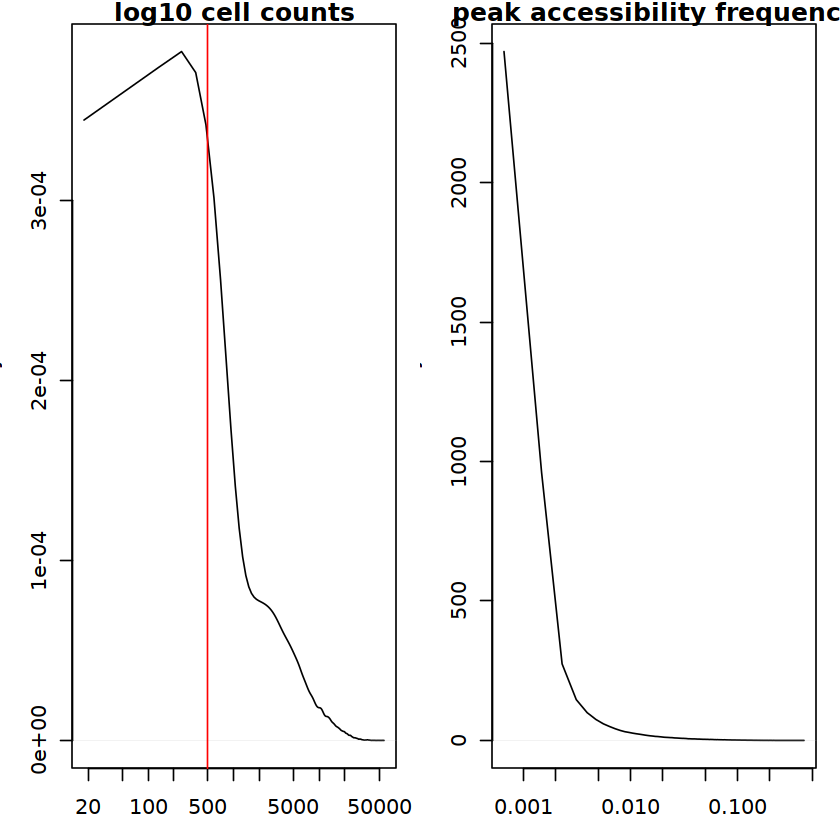

In [6]:
layout(matrix(c(1:2), ncol=2))
par(mar=c(3,3,1,1))
plot(density(cell.counts), main="log10 cell counts", log="x")
abline(v=500, col="red")
plot(density(site.freq), main="peak accessibility frequency", log="x")

In [10]:
# get per cell feature counts --------------------------------------------
cell.counts <- Matrix::colSums(soc.obj$counts)  # count number of features with Tn5 insertions per cell
cell.counts.z <- as.numeric(scale(cell.counts)) # convert features counts into Z-scores
cell.counts.threshold <- max(c(cell.counts[cell.counts.z < -1], 100)) # minimum feature counts (greater of 1 std or 1000)

# clean sparse counts matrix ---------------------------------------------
soc.obj <- cleanData(soc.obj, 
                     min.c=cell.counts.threshold,  # minimum number of accessible features per cell
                     min.t=0.03,  # minimum feature frequency across cells
                     max.t=0.1, # maximum feature frequency across cells
                     verbose=T)

   * Input: cells = 32799 | peaks = 609258

   * Filtered: cells = 23941 | peaks = 31496



In [11]:
# normalize with TFIDF ---------------------------------------------------
soc.obj <- tfidf(soc.obj)

In [12]:
# project with NMF -------------------------------------------------------
soc.obj.reduce_dim <- reduceDims(soc.obj,
                      method="SVD", 
                      n.pcs=50, 
                      svd_slotName="SVD")


# reduce to 2-dimensions with UMAP ---------------------------------------
soc.obj.project_umap <- projectUMAP(soc.obj.reduce_dim, 
                       verbose=T,
                       k.near=25,
                       m.dist=0.01,
                       svd_slotName="SVD")

 - non-linear dimensionality reduction with UMAP ...

08:04:03 UMAP embedding parameters a = 1.896 b = 0.8006

08:04:03 Read 23941 rows and found 50 numeric columns

08:04:03 Using Annoy for neighbor search, n_neighbors = 25

08:04:03 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

08:04:09 Writing NN index file to temp file /tmp/RtmpKpzCmZ/file31e598fe3b48

08:04:09 Searching Annoy index using 16 threads, search_k = 2500

08:04:10 Annoy recall = 100%

08:04:13 Commencing smooth kNN distance calibration using 16 threads
 with target n_neighbors = 25

08:04:16 Initializing from normalized Laplacian + noise (using irlba)

08:04:17 Commencing optimization for 200 epochs, with 1050668 positive edges

08:04:59 Optimization finished



In [13]:
tfidf.obj.dob <- detectDoublets(soc.obj.project_umap, threads=10, nTrials=5, 
                                nSample=1000, rdMethod = "SVD", svd_slotName="SVD")

 - Creating synthetic doublets ...

 - Created 115000 synthetic doublets ...

 - Creating original projection ...

 - Merging synthetic and original cells ...

 - Projecting to UMAP ...

 - Computing KNN doublets (SVD)...

 - Computing KNN doublets (UMAP)...



In [14]:
tfidf.obj.dob.filt <- filterDoublets(obj=tfidf.obj.dob, 
                                     filterRatio=1.2, 
                                     removeDoublets=F, 
                                     libraryVar="sampleID",
                                     verbose=TRUE)

 - libraryVar: sampleID



In [15]:
library(tidyverse)
archR_graph_1 <- as_tibble(tfidf.obj.dob.filt$meta) %>% 
    ggplot(., aes(doubletscore, color = d.type)) + geom_bar() + facet_grid(sampleID~.) + 
    ggtitle("ArchR Doublet Calls")

In [24]:
remove_top_x_doublet_percent <- function(obj) { 
    prcnt_to_remove <- 96 - (96*((1-(1/96))^25)) - (25*((1-(1/96))**24))
    calculated_value <- (100 - prcnt_to_remove)/100
    
    old_meta <- obj$meta
    remove_val_greater <- sort(old_meta$doubletscore)[calculated_value*length(old_meta$doubletscore)]
    
    grabbed_graph <- as_tibble(obj$meta) %>% 
        mutate(filter_bool = case_when(doubletscore < remove_val_greater ~ "non_filtered",
                                       doubletscore > remove_val_greater ~ "filtered"))  %>% 
        ggplot(., aes(doubletscore, color = filter_bool)) + geom_bar() + facet_grid(sampleID~.)
    
    new_meta <- subset(old_meta, doubletscore < remove_val_greater) 
    removed_cells <- nrow(old_meta) - nrow(new_meta)
    new_meta$d.type <- "singlet"
    
    obj$pre.doublet.meta <- old_meta
    obj$meta <- new_meta
    obj$counts <- obj$counts[,rownames(obj$meta)]
    obj$counts <- obj$count[Matrix::rowSums(obj$counts)>0,]
    obj$counts <- obj$count[,Matrix::colSums(obj$counts)>0]
    obj[["UMAP"]] <- obj[["UMAP"]][colnames(obj$counts),]
    obj[["PCA"]] <- obj[["PCA"]][colnames(obj$counts),]
    new.num.cells <- ncol(obj$counts)
    message("   * Doublet filtering * Number cells removed= ", removed_cells,"  Filtered: cells = ", ncol(obj$counts), " | peaks = ", nrow(obj$counts))

    
    return(obj)

}

plot_top_x_doublet_percent <- function(obj) { 
    prcnt_to_remove <- 96 - (96*((1-(1/96))^25)) - (25*((1-(1/96))**24))
    calculated_value <- (100 - prcnt_to_remove)/100
    
    old_meta <- obj$meta
    remove_val_greater <- sort(old_meta$doubletscore)[calculated_value*length(old_meta$doubletscore)]
    
    grabbed_graph <- as_tibble(obj$meta) %>% 
        mutate(filter_bool = case_when(doubletscore < remove_val_greater ~ "non_filtered",
                                       doubletscore > remove_val_greater ~ "filtered")) 

    
    return(grabbed_graph)

}


remove_doublets <- function(obj) { 
    
    old_meta <- obj$meta

    new_meta <- subset(old_meta, d.type == "singlet") 
    removed_cells <- nrow(old_meta) - nrow(new_meta)
    
    obj$pre.doublet.meta <- old_meta
    obj$meta <- new_meta
    obj$counts <- obj$counts[,rownames(obj$meta)]
    obj$counts <- obj$count[Matrix::rowSums(obj$counts)>0,]
    obj$counts <- obj$count[,Matrix::colSums(obj$counts)>0]
    obj[["UMAP"]] <- obj[["UMAP"]][colnames(obj$counts),]
    obj[["PCA"]] <- obj[["PCA"]][colnames(obj$counts),]
    new.num.cells <- ncol(obj$counts)
    message("   * Doublet filtering * Number cells removed= ", removed_cells,"  Filtered: cells = ", ncol(obj$counts), " | peaks = ", nrow(obj$counts))

    
    return(obj)

}

In [17]:
    prcnt_to_remove <- 96 - (96*((1-(1/96))^25)) - (25*((1-(1/96))**24))
    calculated_value <- (100 - prcnt_to_remove)/100
    calculated_value
    
    old_meta <- tfidf.obj.dob.filt$meta
    remove_val_greater <- sort(old_meta$doubletscore)[calculated_value*length(old_meta$doubletscore)]
    as_tibble(old_meta) %>% 
        mutate(filter_bool = case_when(doubletscore < remove_val_greater ~ "non_filtered",
                                       doubletscore > remove_val_greater ~ "filtered"))  %>% 
        group_by(filter_bool)  %>% 
        summarise(count = n())


[1] 0.9733363

filter_bool  count
1 filtered       636
2 non_filtered 23299
3 NA               6

In [18]:
calculated_value*length(old_meta$doubletscore)

[1] 23302.65

In [19]:
library(tidyverse)

birthday_problem <- plot_top_x_doublet_percent(tfidf.obj.dob.filt)
birthday_problem_graph <- ggplot(birthday_problem, aes(doubletscore, color = filter_bool)) + 
geom_bar() + 
facet_grid(sampleID~.) + 
ggtitle("Birthday Problem")

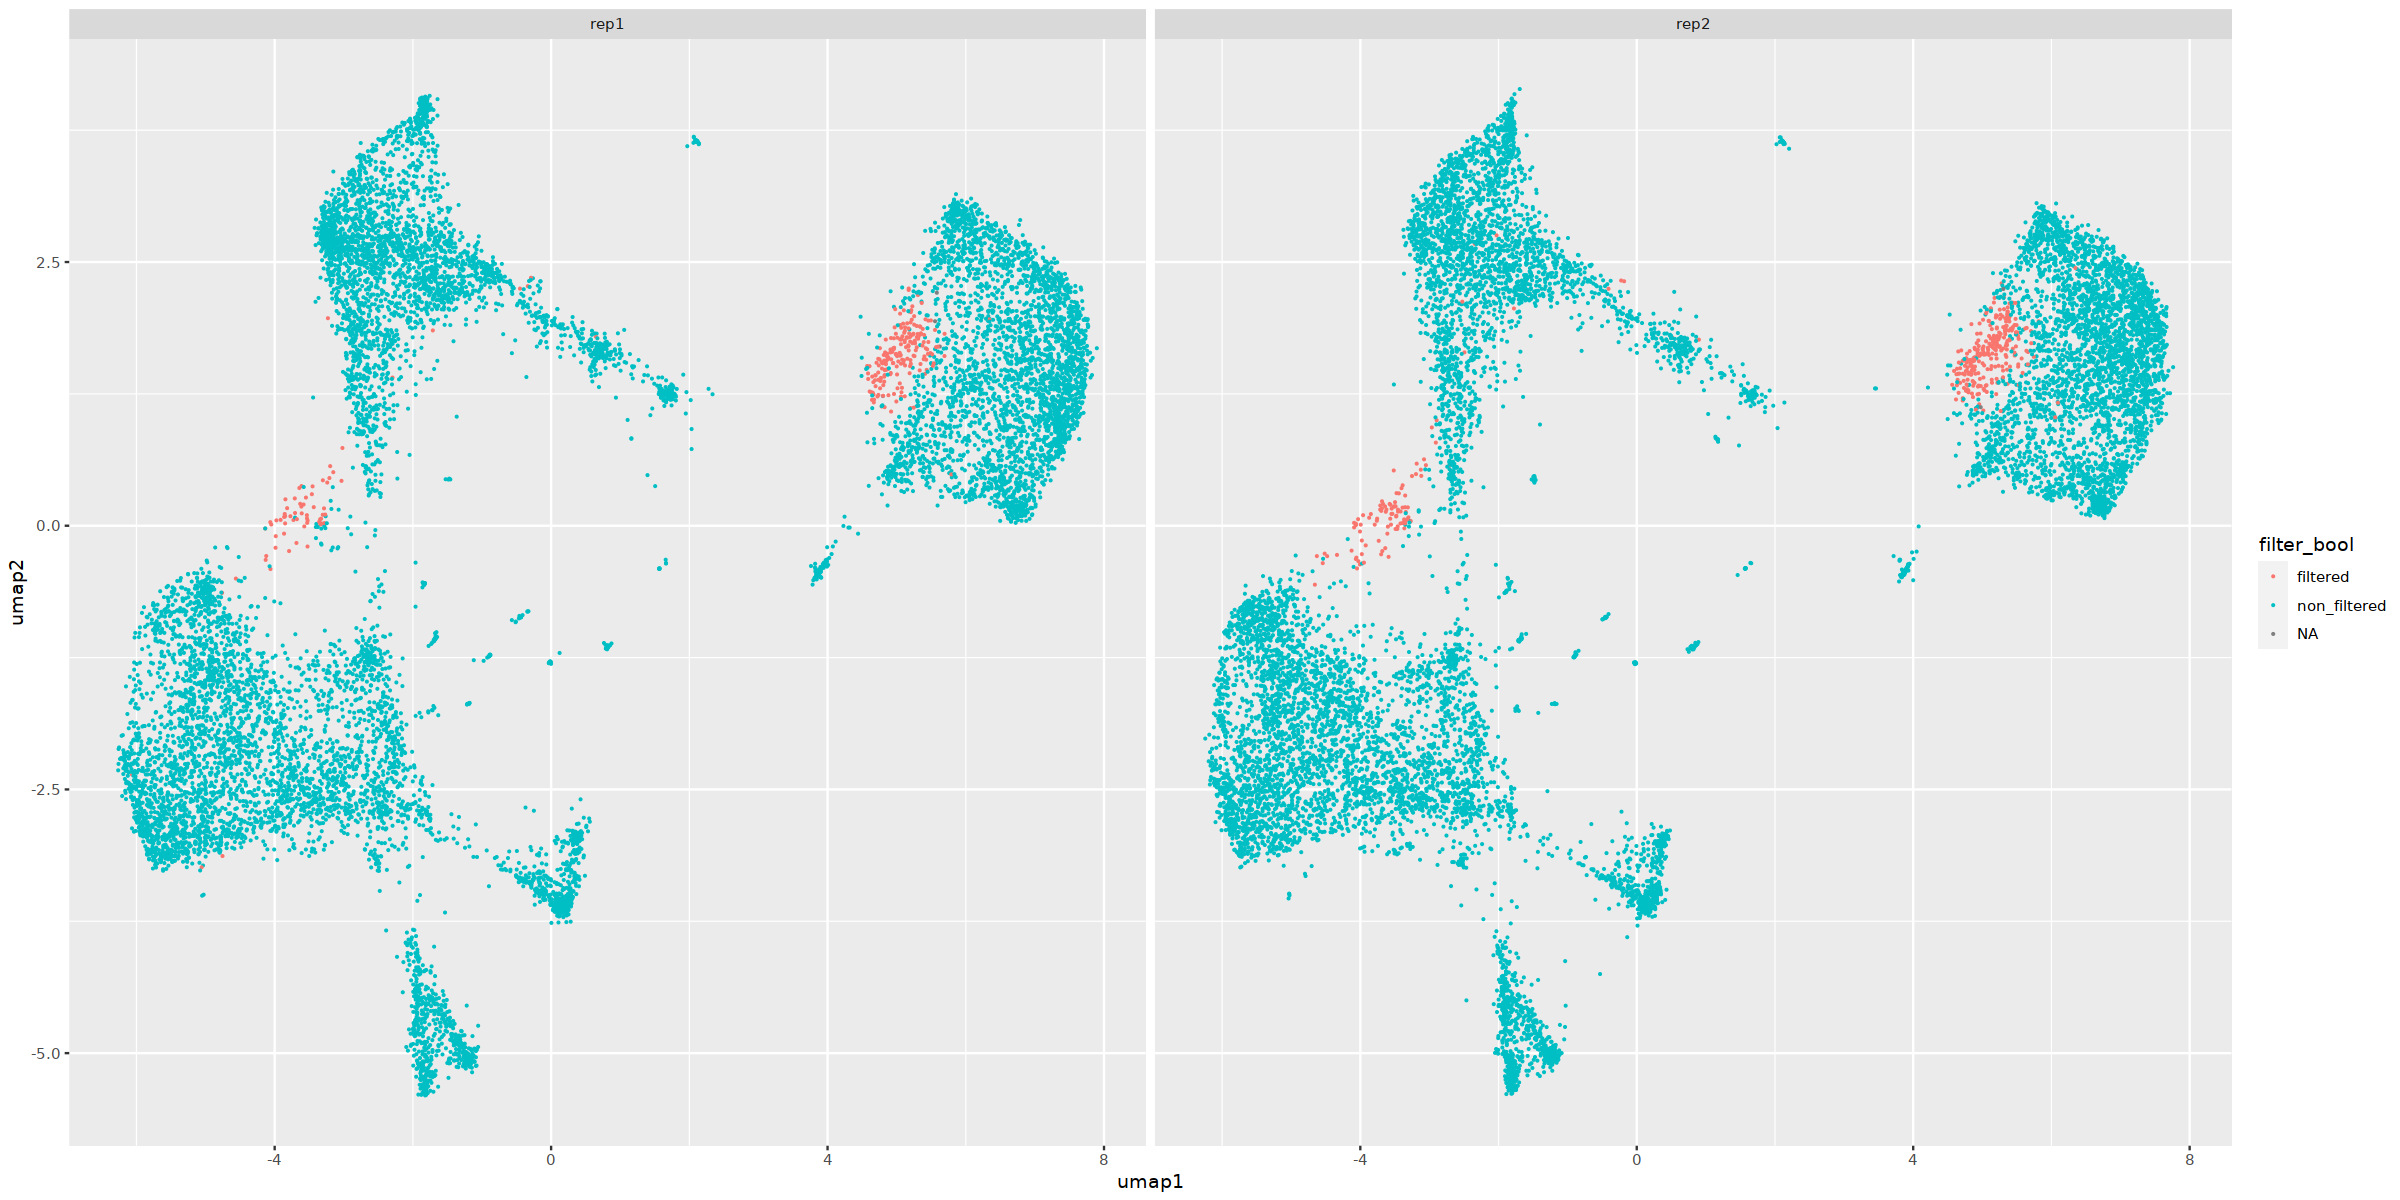

In [20]:
options(repr.plot.width=20, repr.plot.height=10)
ggplot(birthday_problem ,aes(umap1, umap2, color = filter_bool)) + 
    geom_jitter(size = .1) + facet_grid(.~sampleID)

In [21]:
birthday_problem  %>% 
    group_by(filter_bool)  %>% 
    summarise(n())

filter_bool  n()  
1 filtered       636
2 non_filtered 23299
3 NA               6

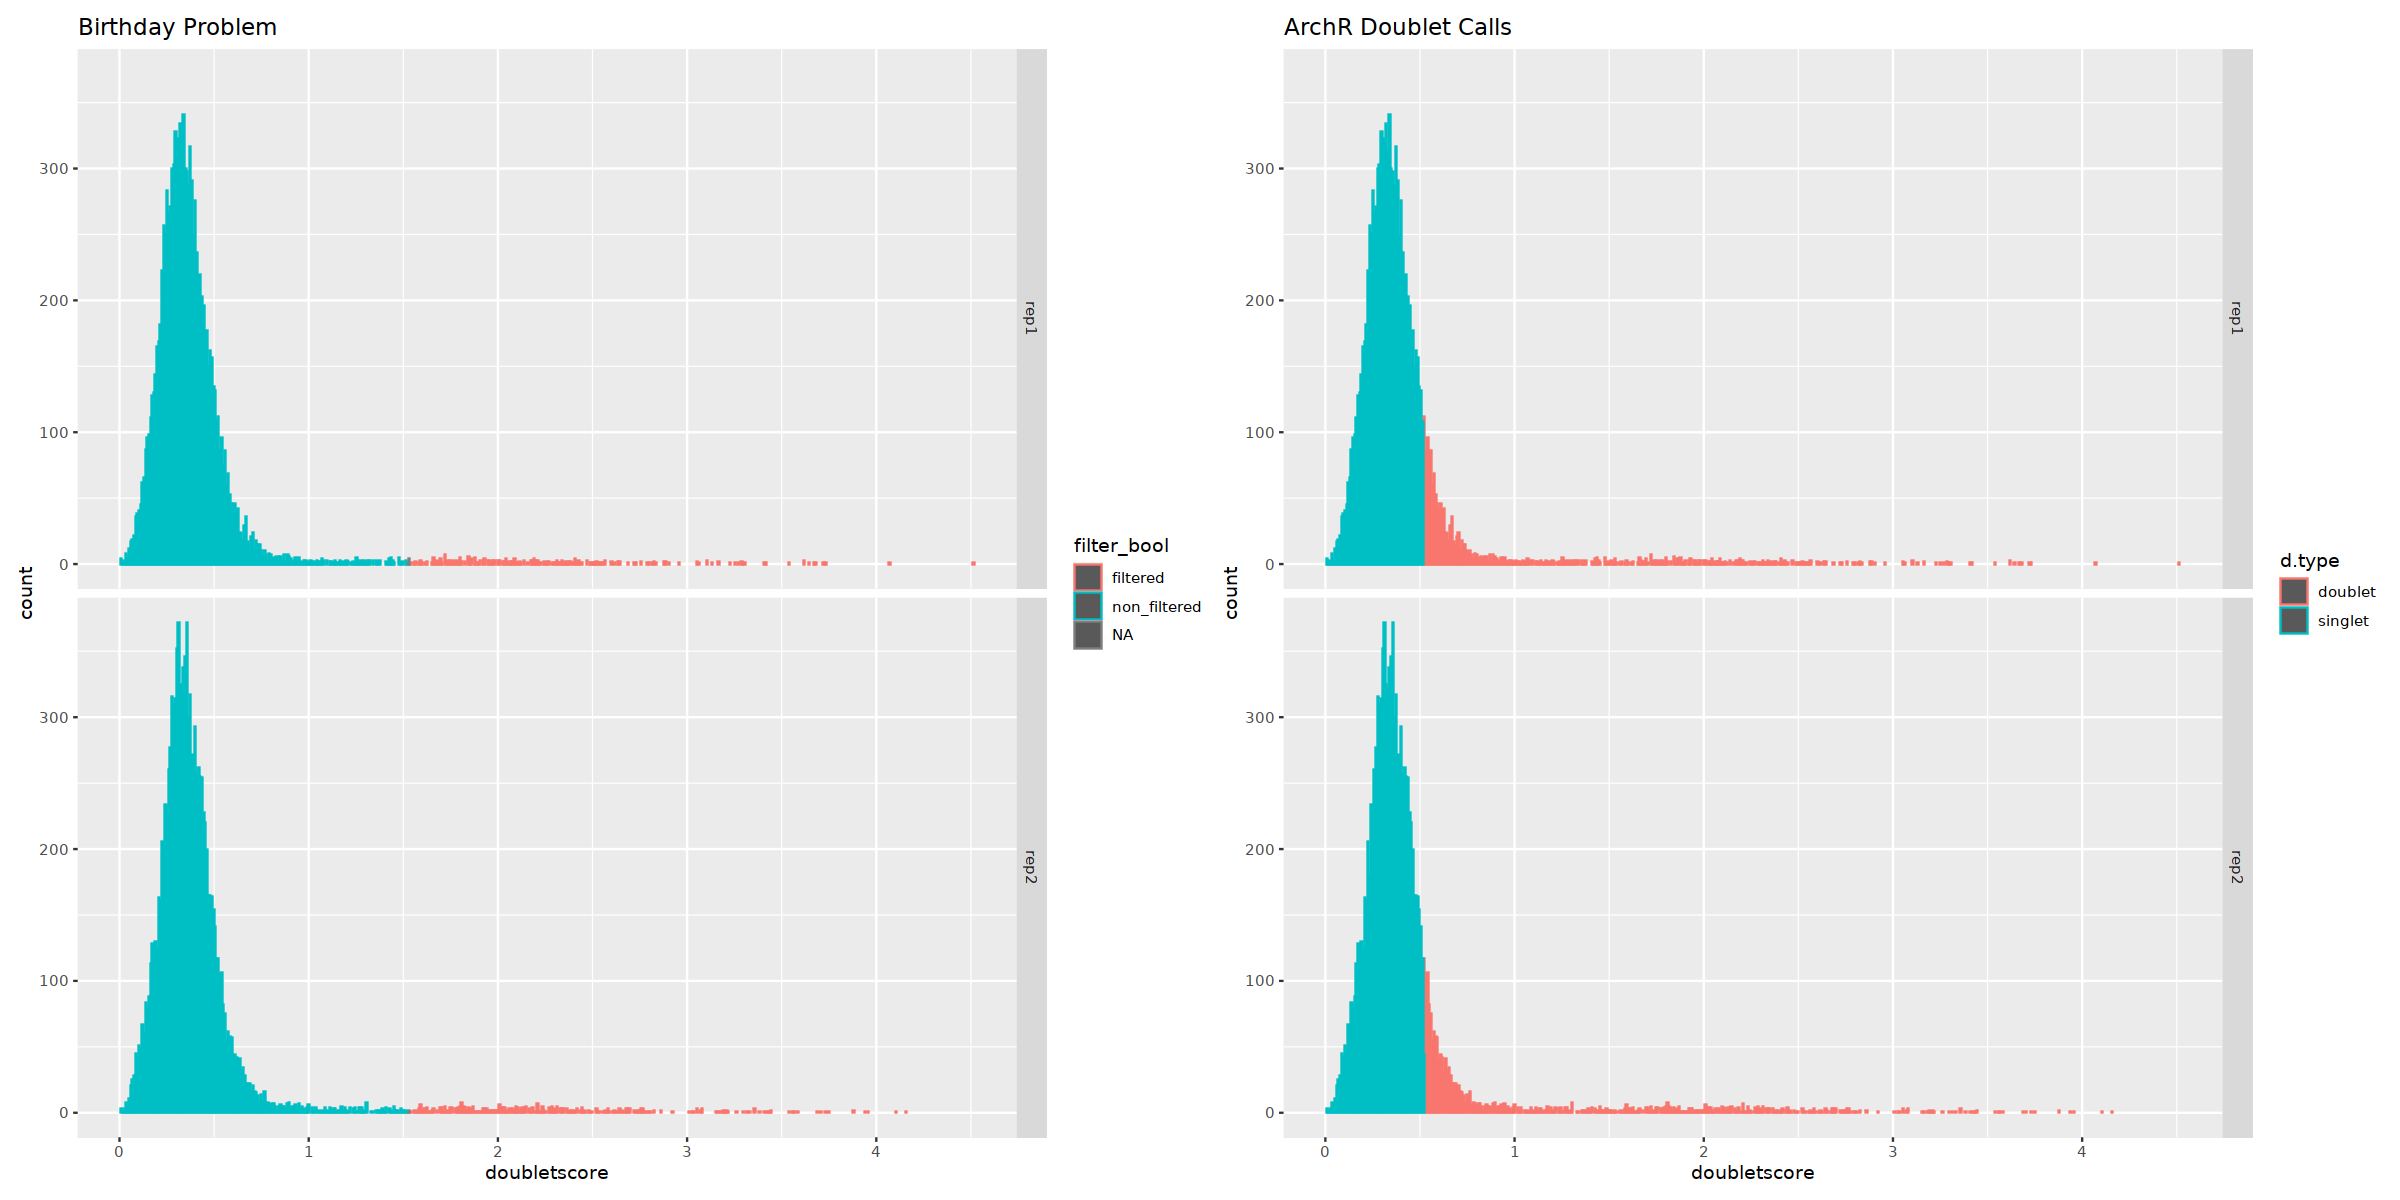

In [22]:
options(repr.plot.width=20, repr.plot.height=10)

birthday_problem_graph + archR_graph_1

In [25]:
tfidf.obj.dob.filt.removed <- remove_doublets(tfidf.obj.dob.filt)

   * Doublet filtering * Number cells removed= 3440  Filtered: cells = 20501 | peaks = 31496



In [28]:
?callClusters

ℹ Rendering development documentation for "callClusters"


 - filtering outliers in UMAP manifold (z-score e.thresh = 3) ...

 - creating seurat object for graph-based clustering ...

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 20121
Number of edges: 1798792

Running Louvain algorithm...
Maximum modularity in 100 random starts: 0.8078
Number of communities: 36
Elapsed time: 60 seconds


17 singletons identified. 19 final clusters.

 - finished graph-based clustering ...

   * removing low quality clusters ...

   * filtering per-cluster outliers (z-score filtDistClst2 = 5) ...

   * total number of cells surviving subcluster filtering = 19826

 - filtering clusters with low cell/read counts ...



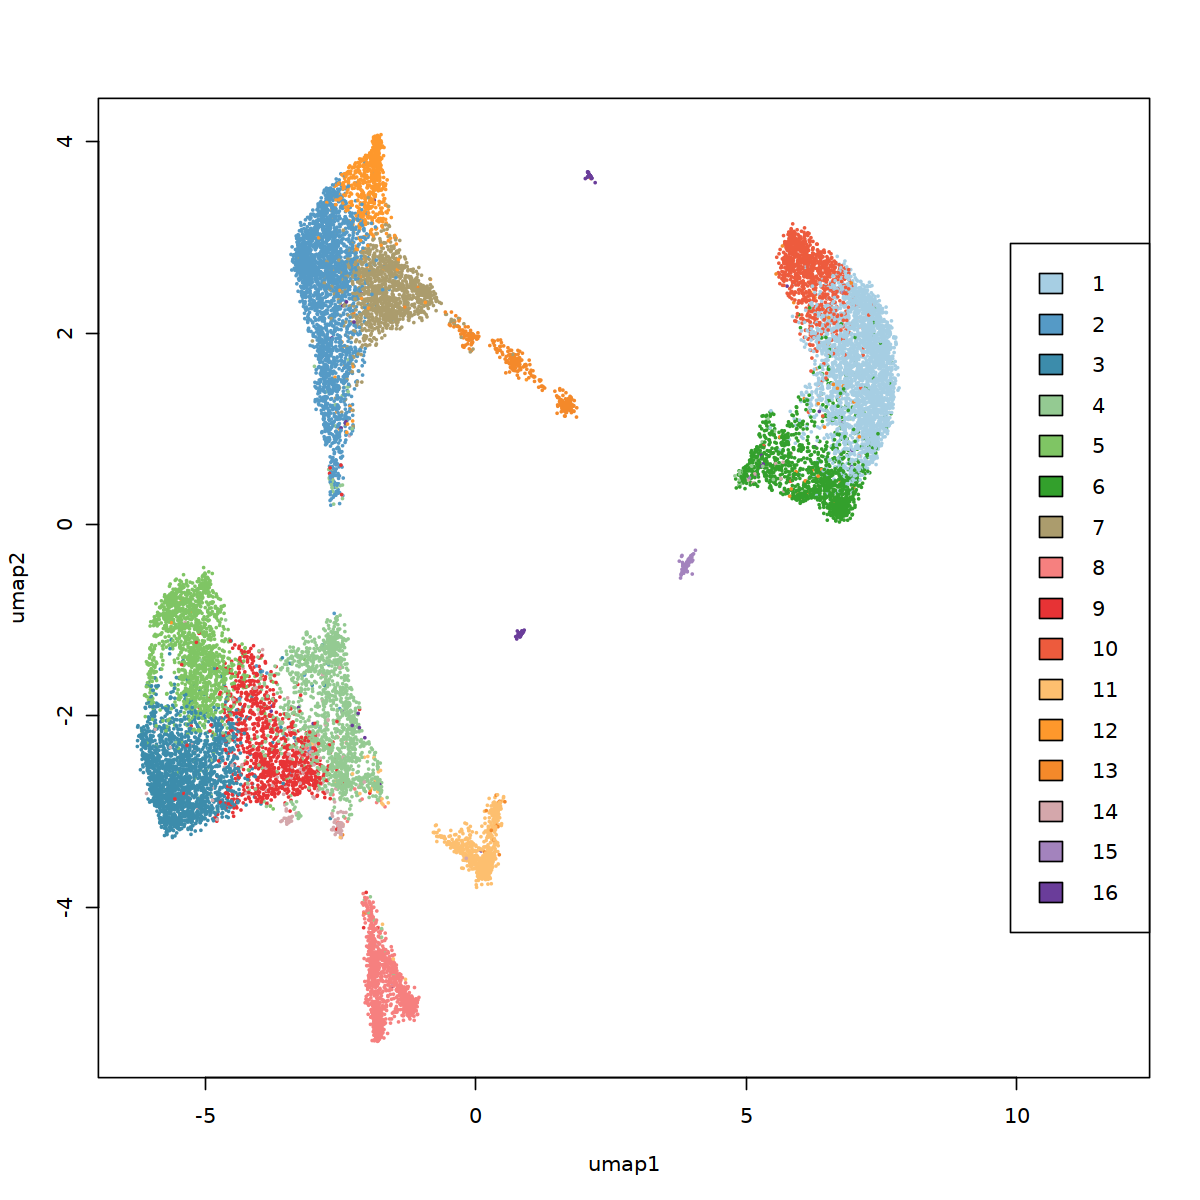

In [29]:
# identify clusters using neighborhood graph -----------------------------
tfidf.obj.dob.filt.clusters <- callClusters(tfidf.obj.dob.filt.removed, 
                        res=1.2,
                        verbose=T,
                        m.clst = 50,
                        svd_slotName= "SVD",
                        cleanCluster=T)

tfidf.obj.dob.filt.clusters.cleaned <- filterSingle(tfidf.obj.dob.filt.clusters$Clusters, 
            k=25,threshold=3)

tfidf.obj.dob.filt.clusters$Clusters <- tfidf.obj.dob.filt.clusters.cleaned


#plot cluster membership on UMAP embedding ------------------------------
options(repr.plot.width=10, repr.plot.height=10)
plotUMAP(tfidf.obj.dob.filt.clusters, cex=0.3)
#dev.off()



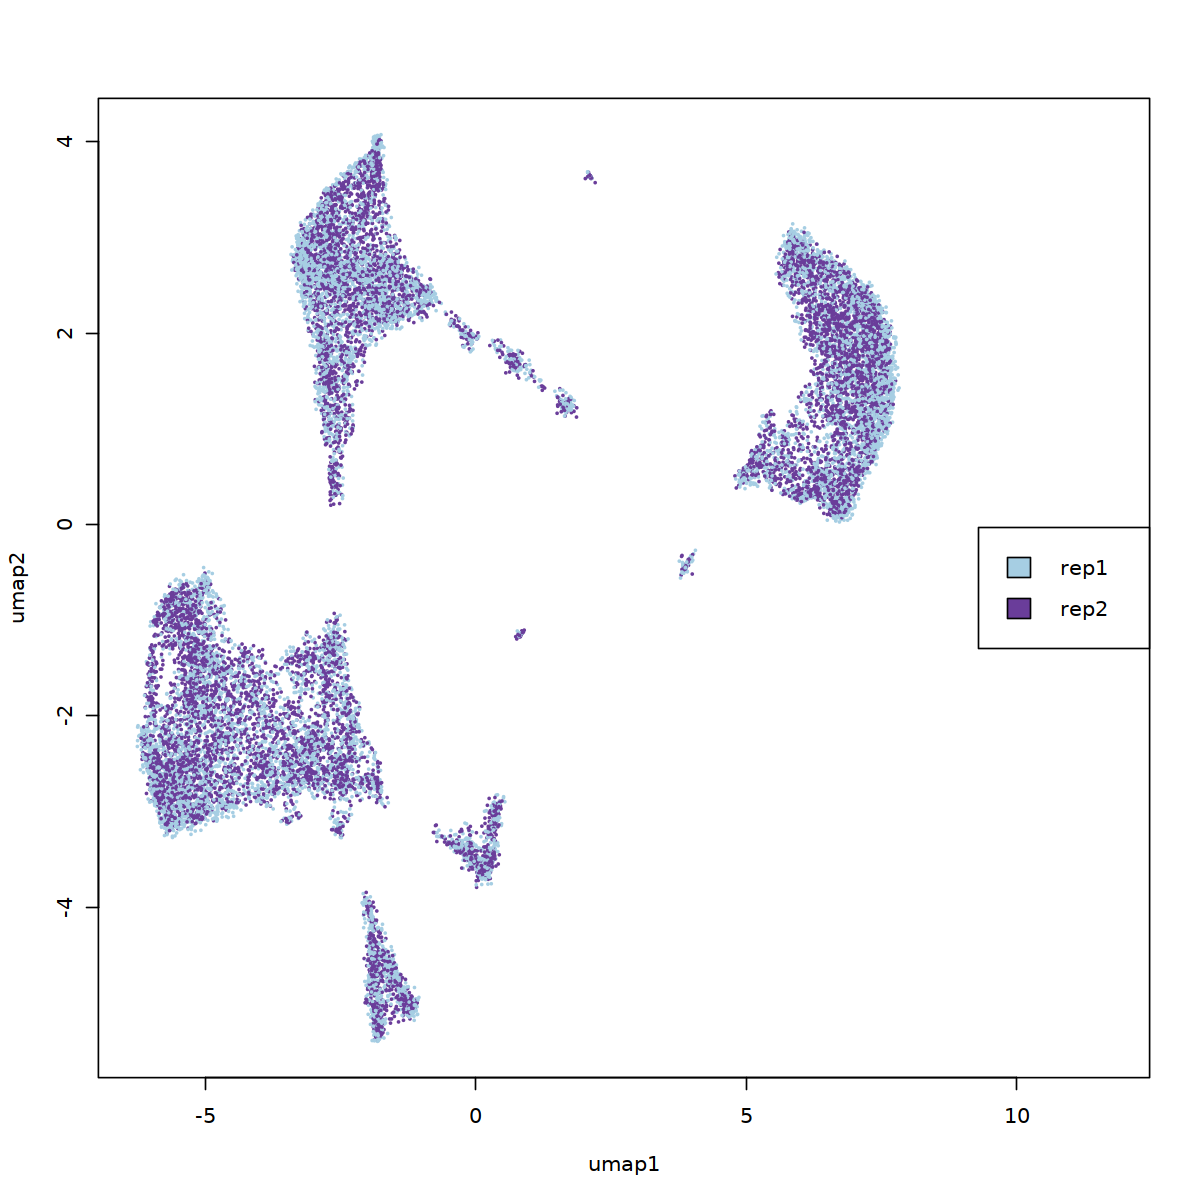

In [30]:
plotUMAP(tfidf.obj.dob.filt.clusters, cex=0.3, column = "sampleID")

In [31]:
library(tidyverse)
cell_converted_trible <- as_tibble(tfidf.obj.dob.filt.clusters$Clusters)  %>% 
    separate(col = "cellID", c("barcode", "plate"), sep = "-", remove = FALSE)

colnames(cell_converted_trible)

[1] "cellID"          "barcode"         "plate"           "total"          
 [5] "tss"             "acrs"            "ptmt"            "nSites"         
 [9] "log10nSites"     "pTSS"            "FRiP"            "pOrg"           
[13] "tss_z"           "acr_z"           "sites_z"         "qc_check"       
[17] "background"      "cellbulk"        "is_cell"         "sampleID"       
[21] "umap1"           "umap2"           "doubletscore"    "d.type"         
[25] "LouvainClusters"

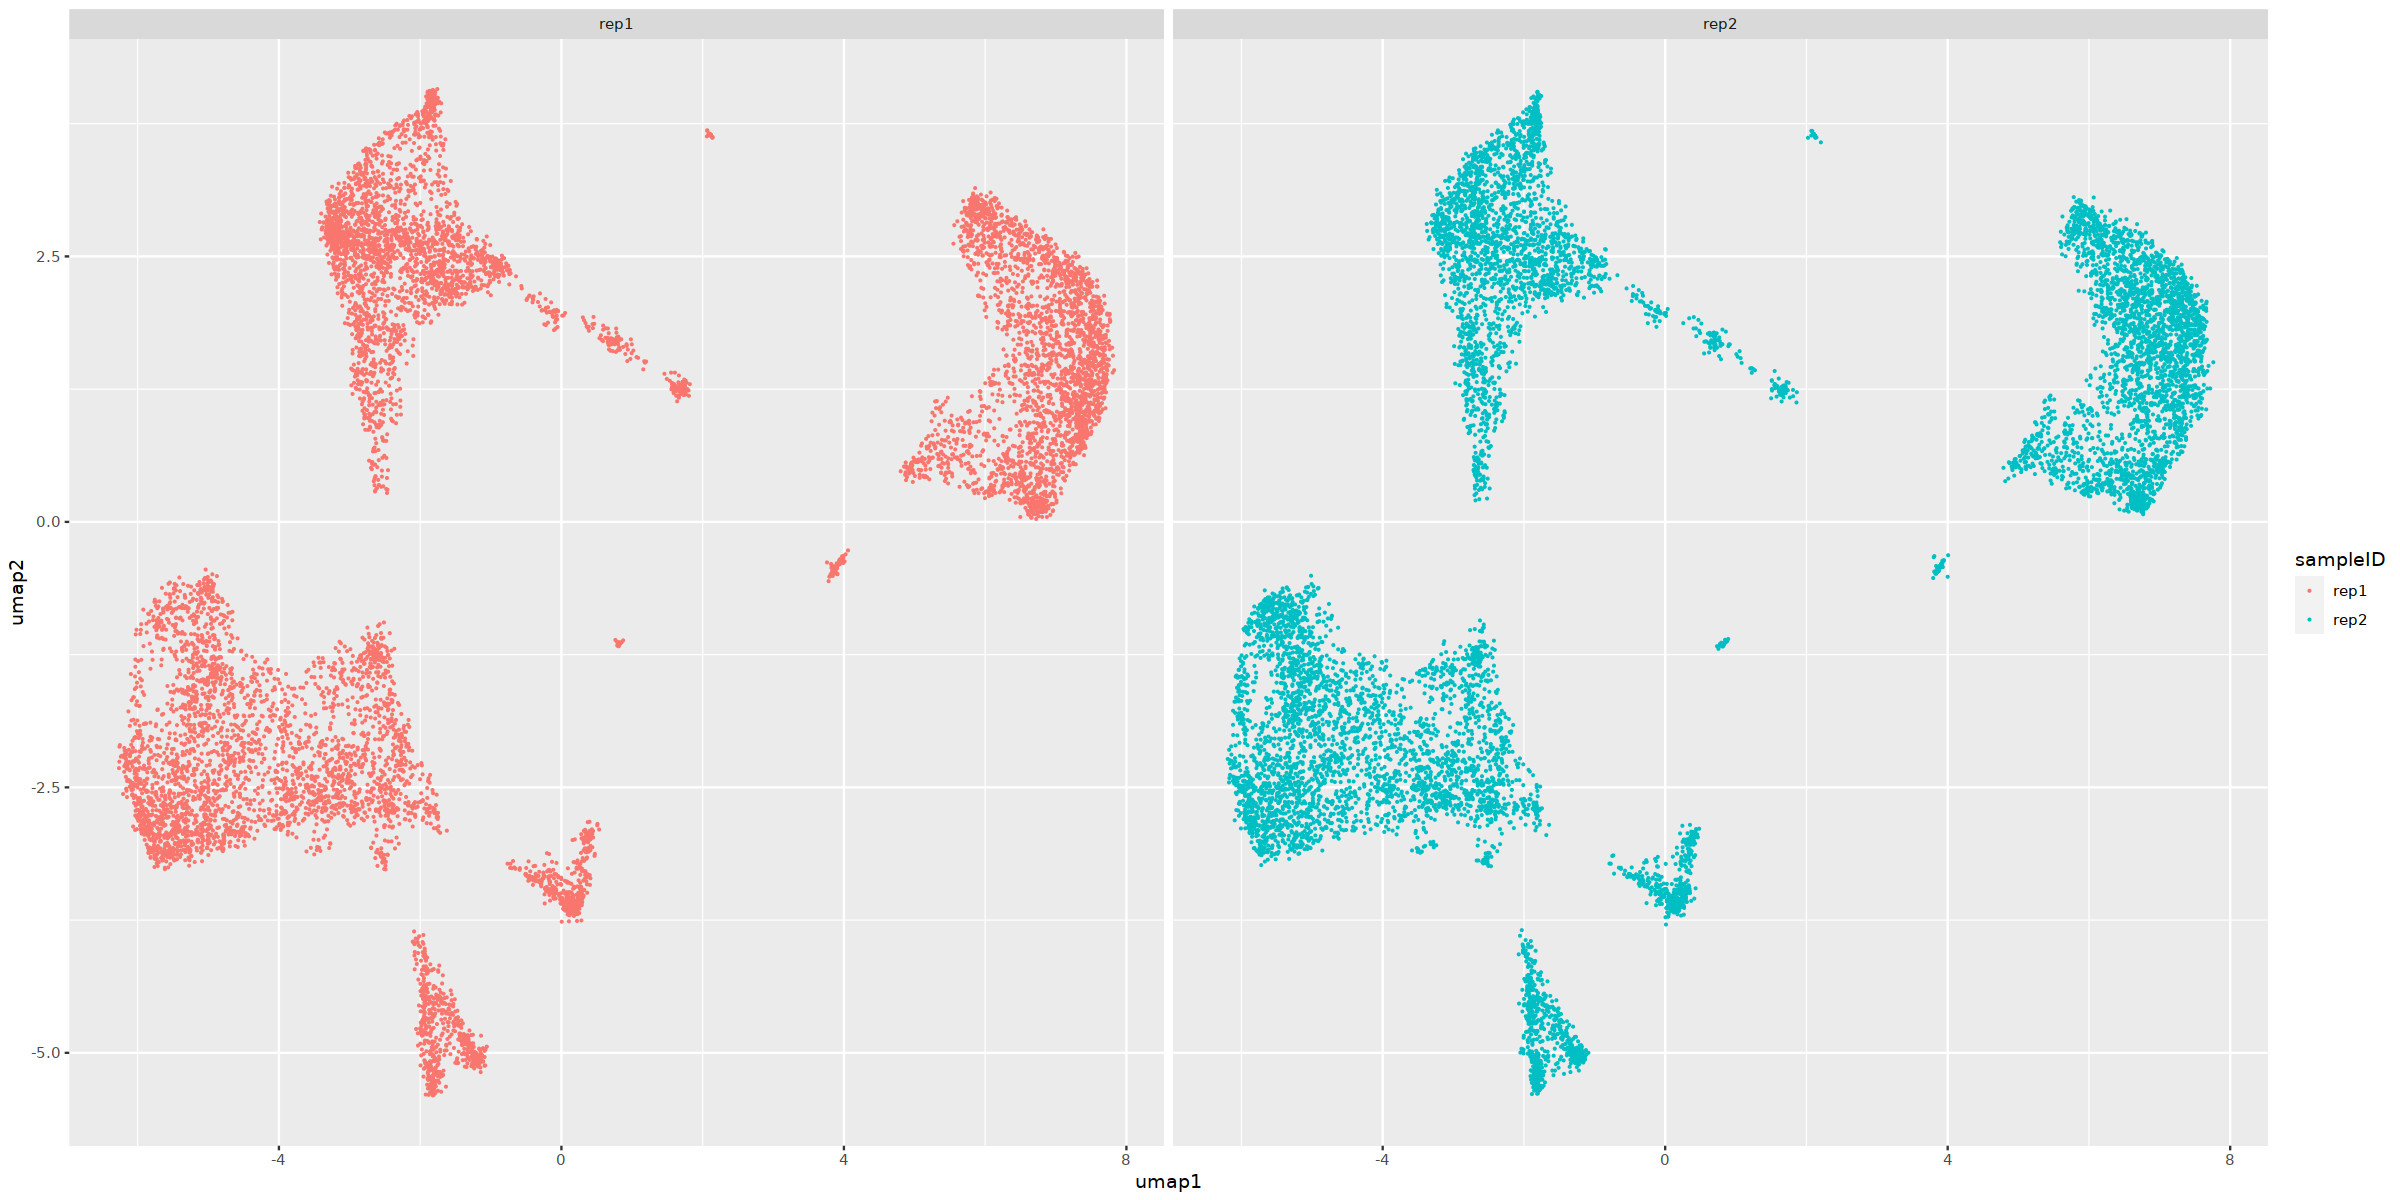

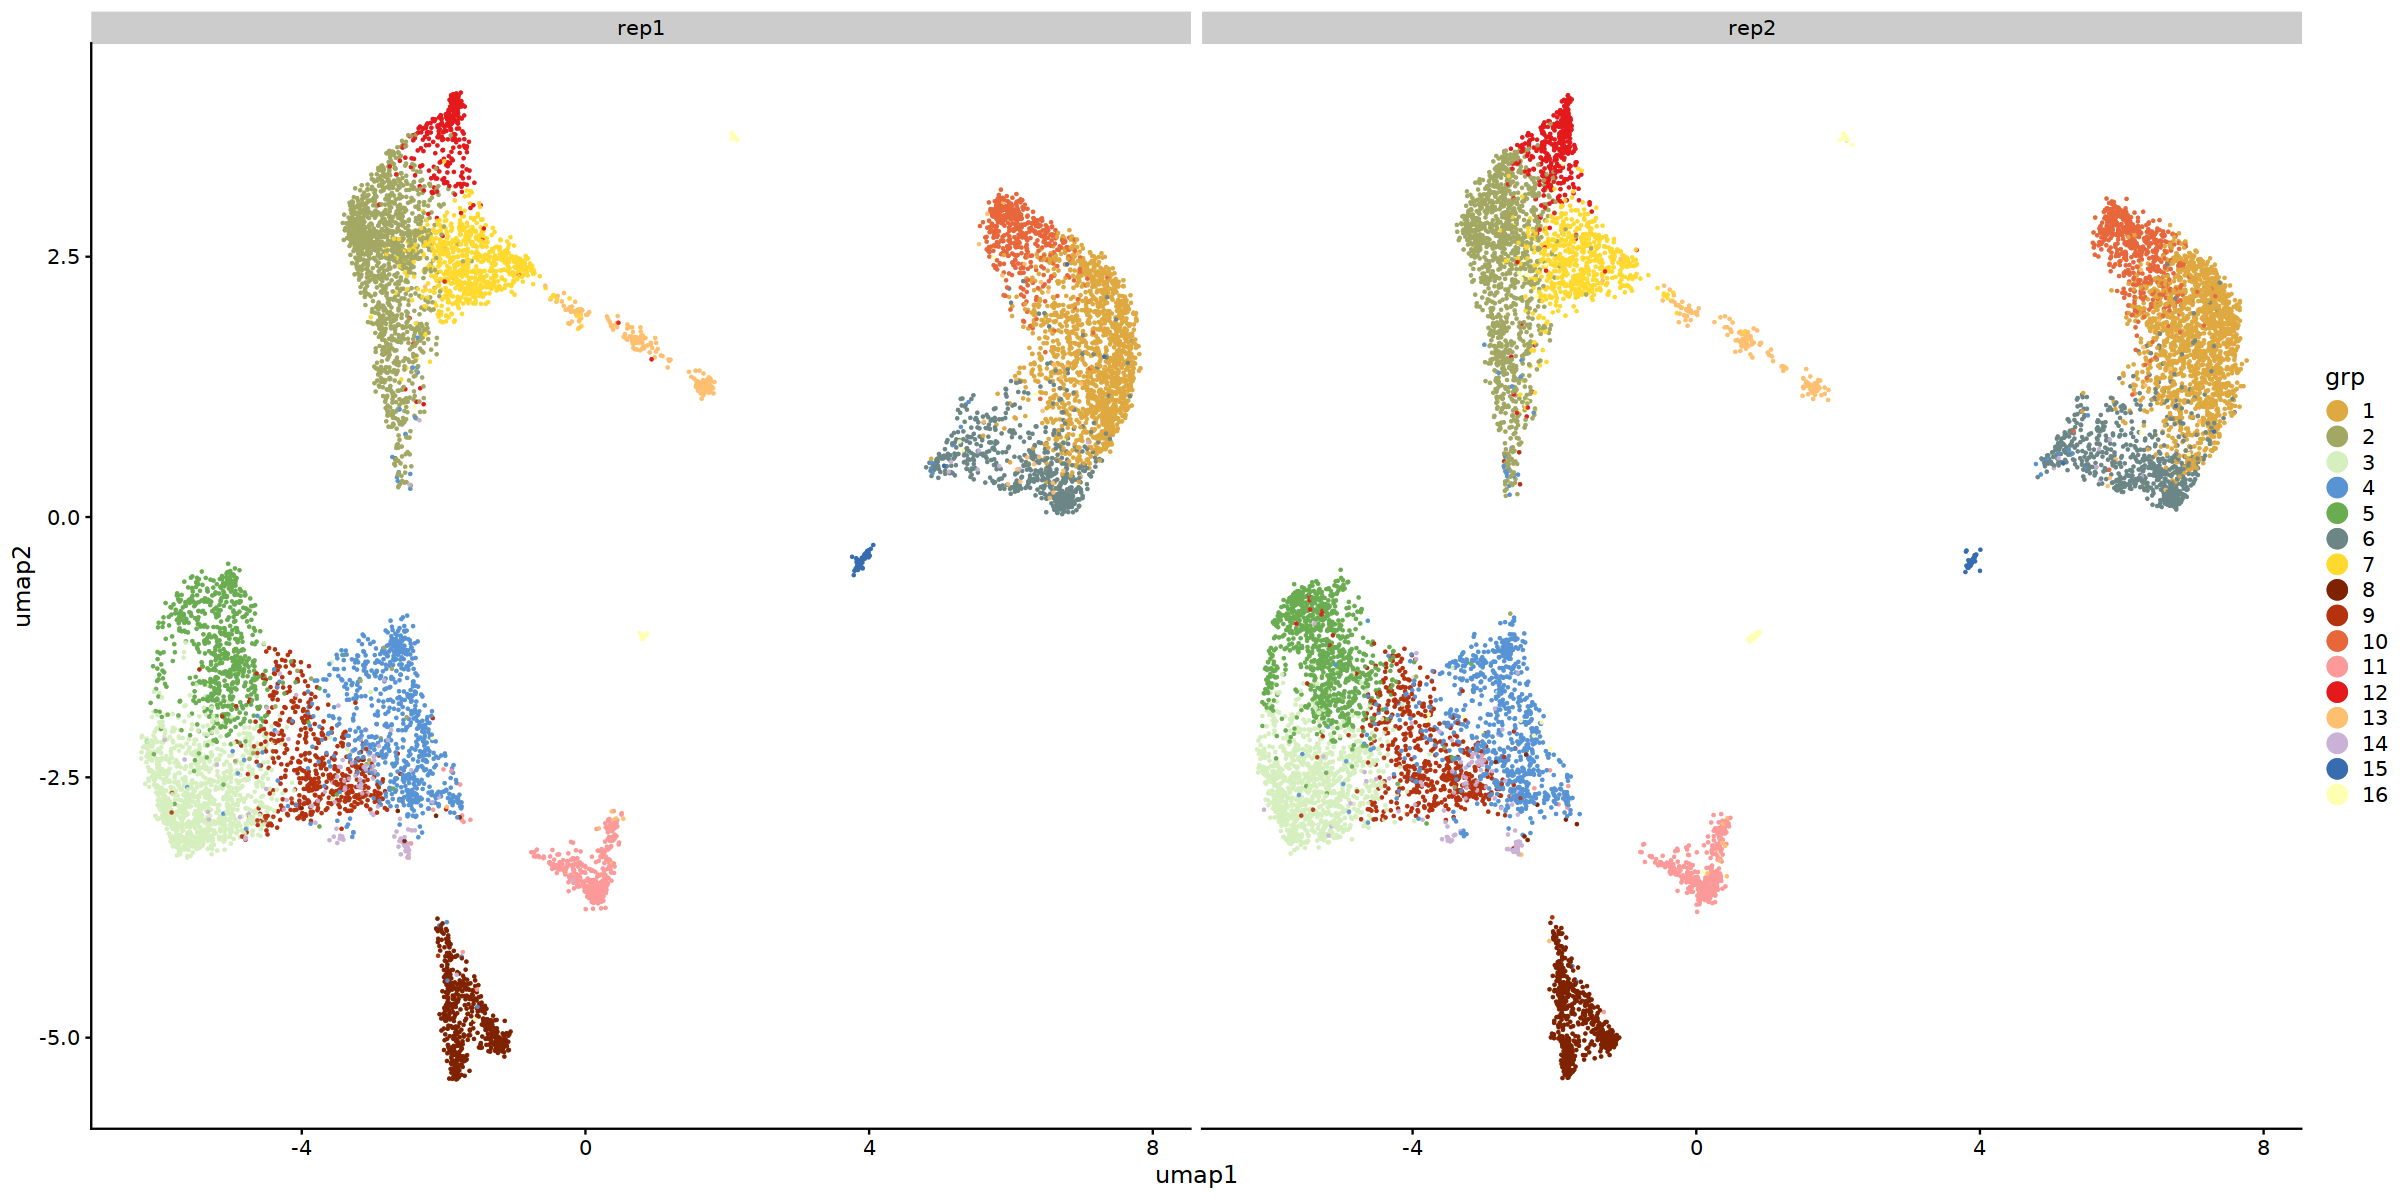

In [34]:
options(repr.plot.width=20, repr.plot.height=10)
cluster_plot <- as_tibble(tfidf.obj.dob.filt.clusters$Clusters)

ggplot(cluster_plot ,aes(umap1, umap2, color = sampleID)) + 
    geom_jitter(size = .1) + facet_grid(.~sampleID)

library(cowplot)
umap_cluster_colors <- c("#DEA940","#A2A763","#D6EEBE","#5894D4","#6AAD51","#6C8686","#FFD92F", "#7f2201","#b53310",
                         "#E7673B","#FB9A99","#E31A1C","#FDBF6F","#CAB2D6","#386CB0","#FFFFB3", "#5dead5","#c11577",
                         "#CCCCCC", "#7570B3","#B15928", "#6A3D9A", "#d87c6a", "#0060e8", "#84c5ff", "#ffd460", "#d81397")


col_scale <- scale_colour_manual(name = "grp", values = umap_cluster_colors)


options(repr.plot.width=20, repr.plot.height=10)
cluster_plot <- as_tibble(tfidf.obj.dob.filt.clusters$Clusters)

ggplot(cluster_plot ,aes(umap1, umap2, color = LouvainClusters)) + 
    col_scale + 
    geom_jitter(size = .1) + facet_grid(.~sampleID) + theme_half_open() +
    guides(colour = guide_legend(override.aes = list(size=5))) +
    geom_point(size = .25, alpha = .8)

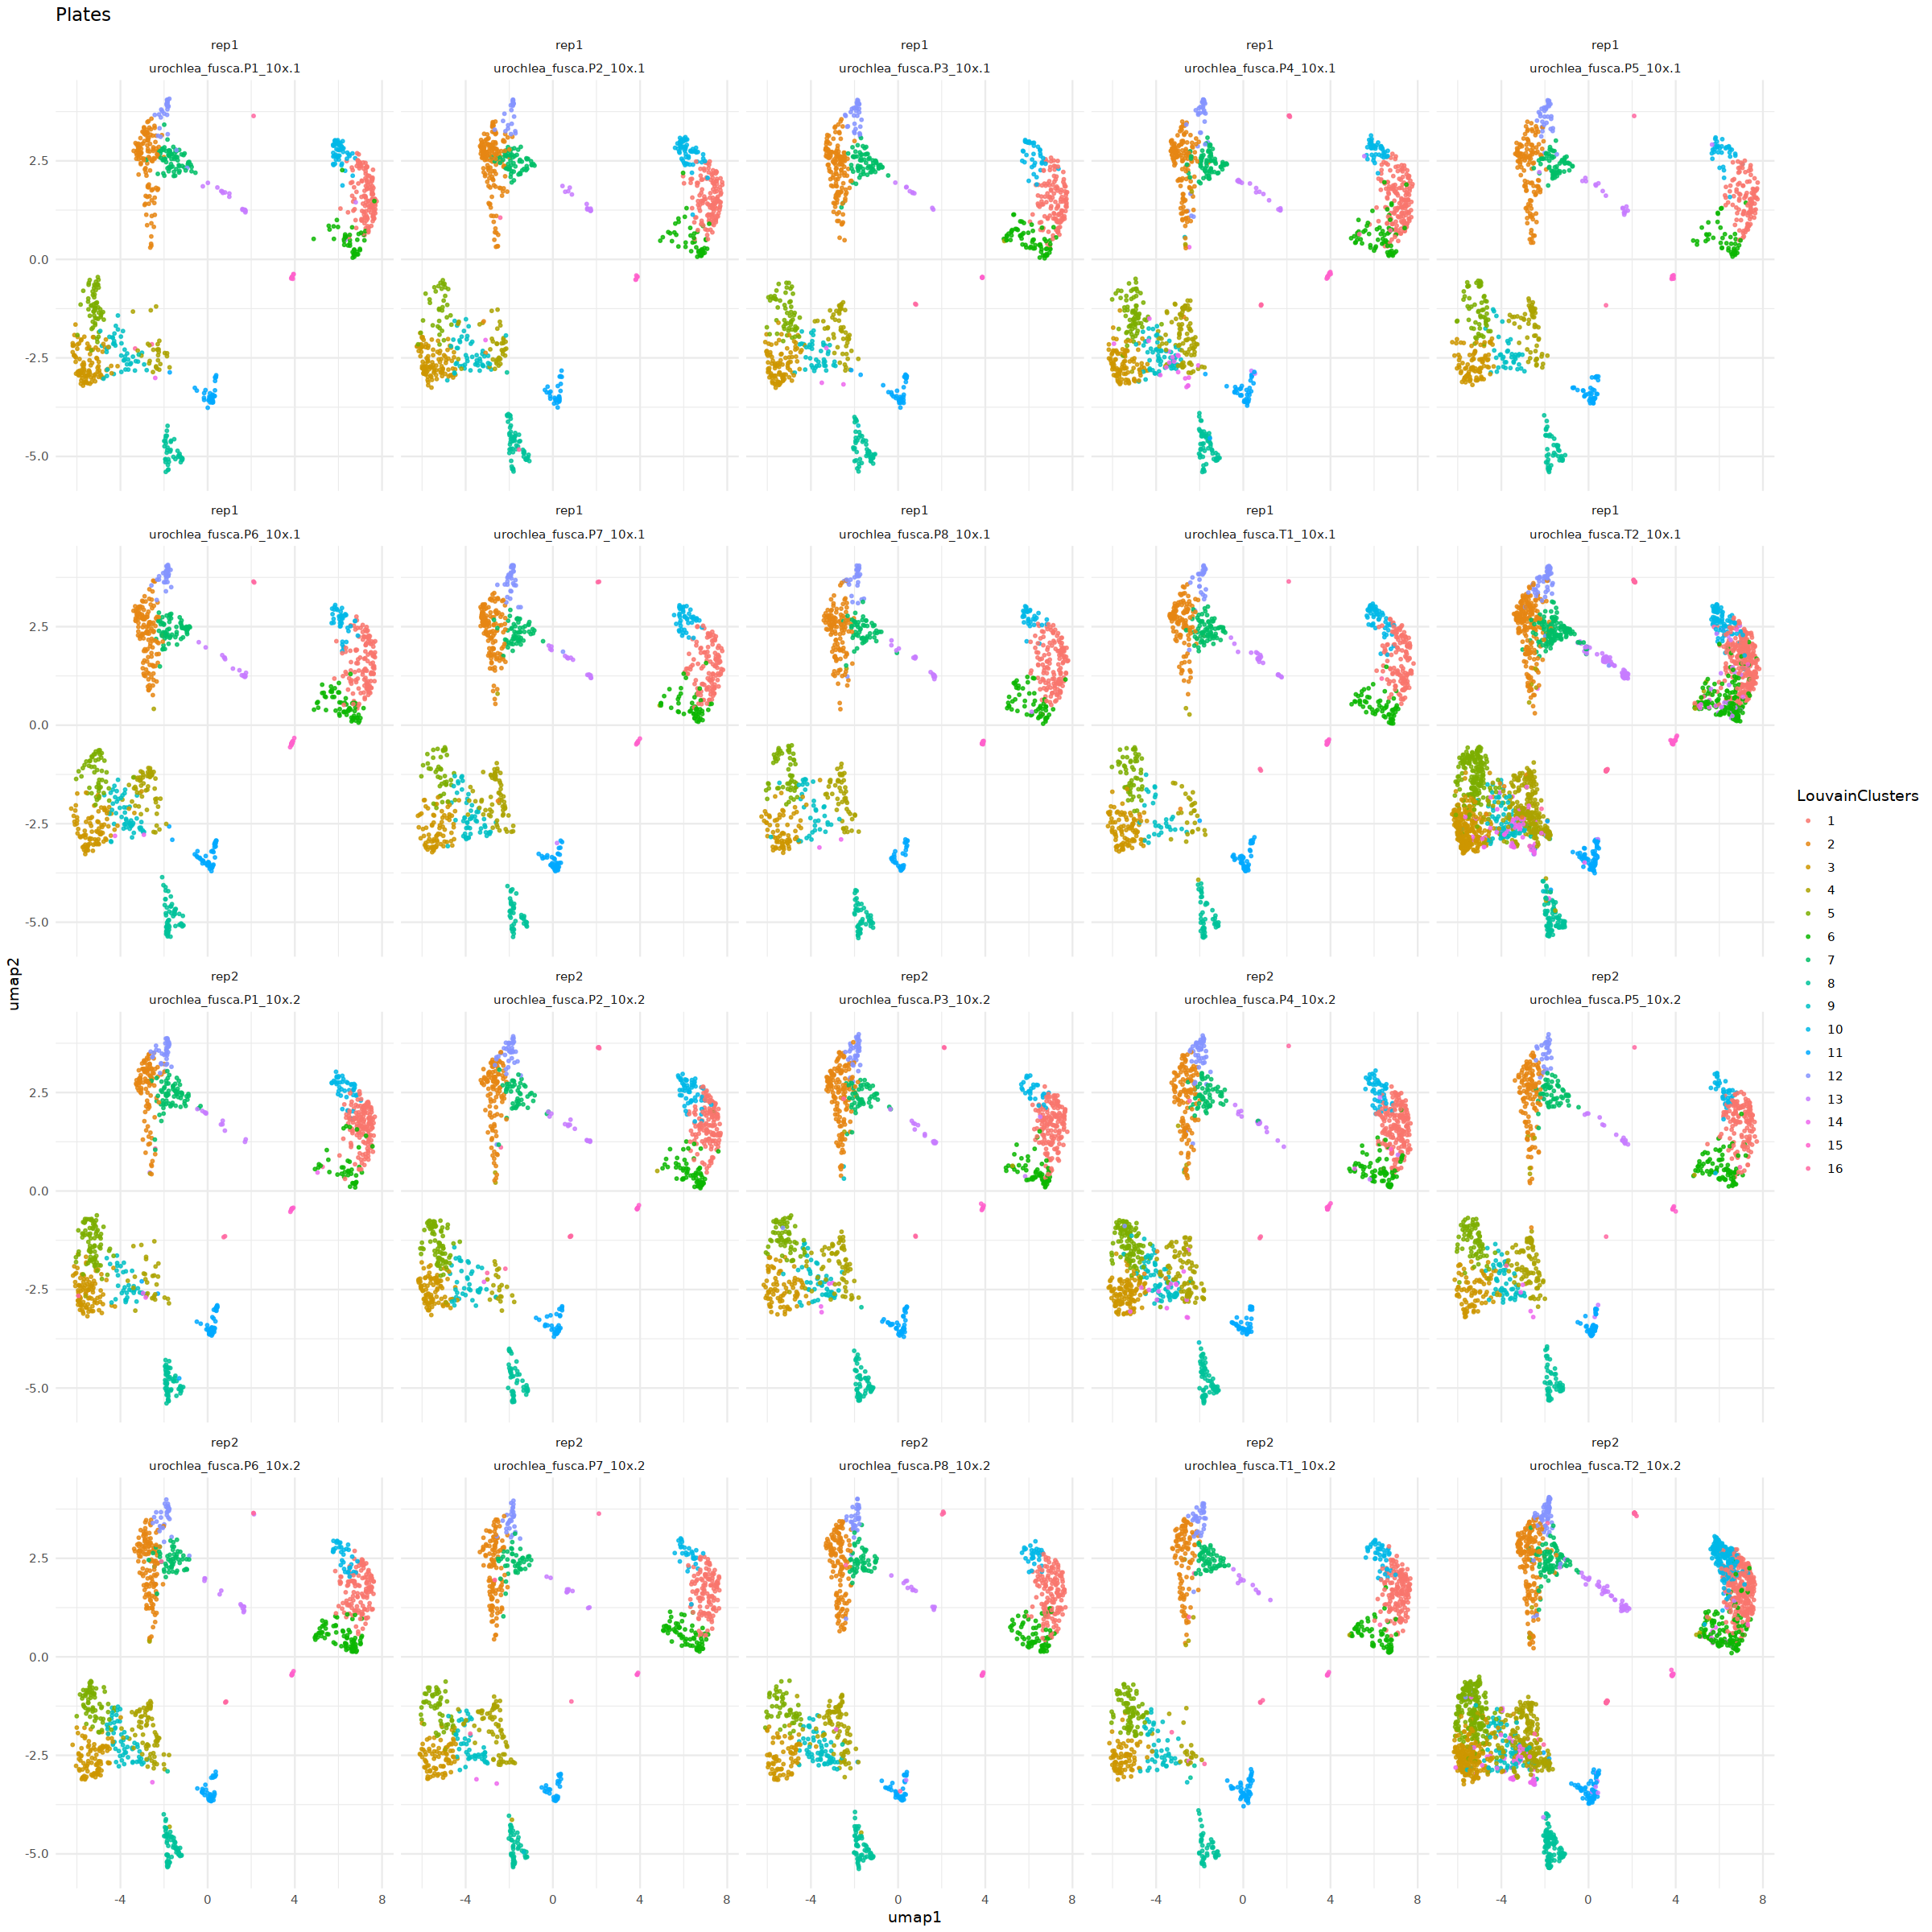

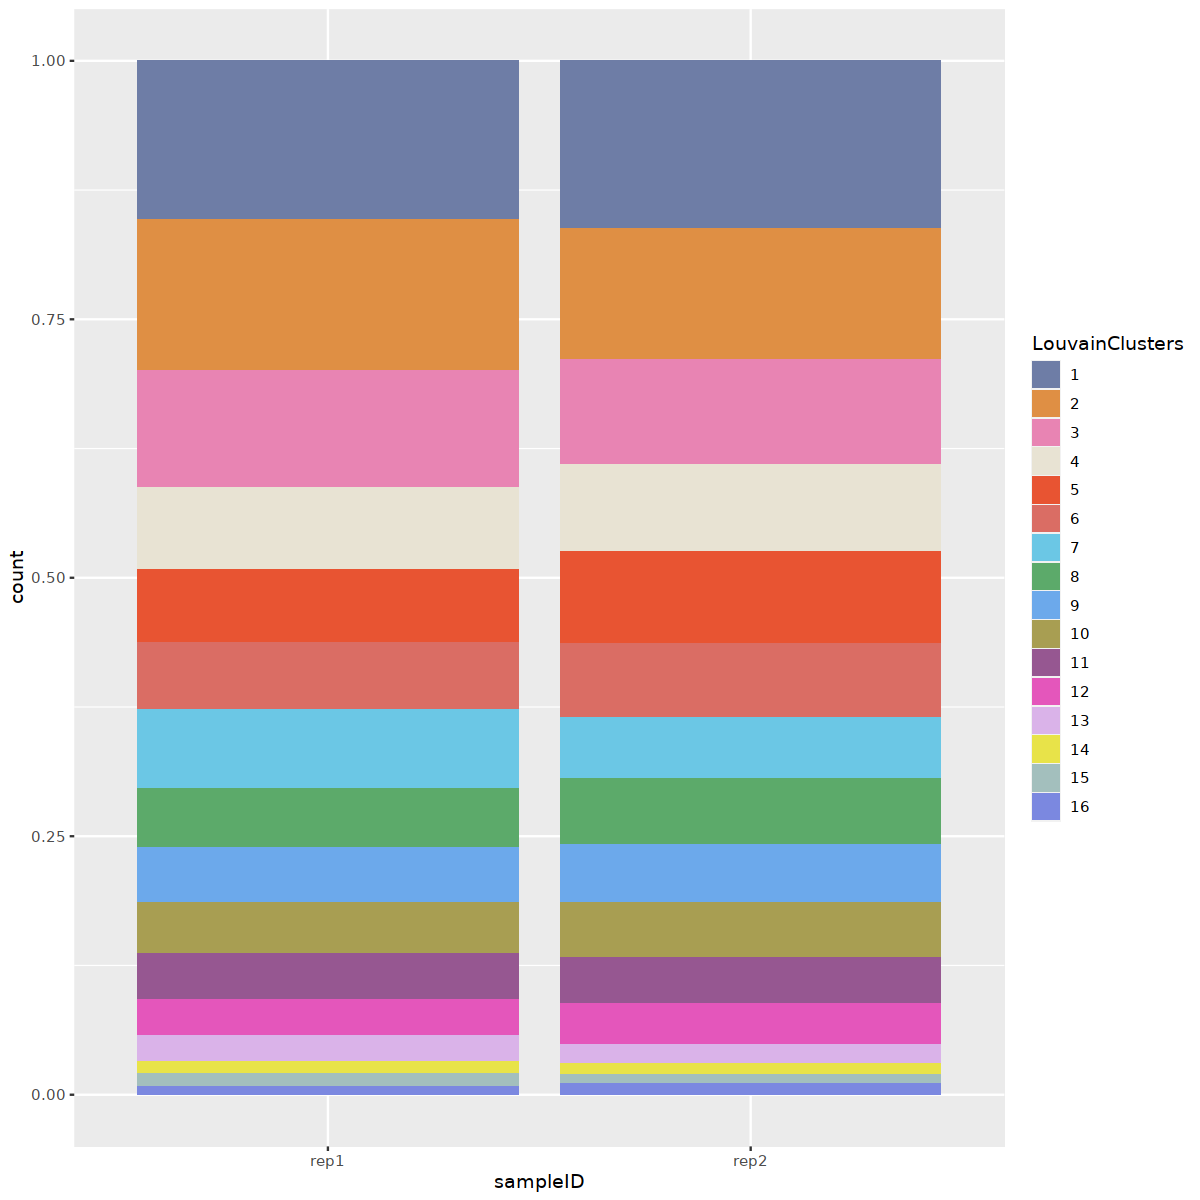

In [35]:
options(repr.plot.width=20, repr.plot.height=20)
cluster_plot  %>% 
    separate(col = "cellID", c("barcode", "plate"), sep = "-", remove = FALSE)  %>% 
    ggplot(., aes(umap1, umap2, color = LouvainClusters)) + 
    geom_point(size = .6, alpha = .8) + theme_minimal() + ggtitle("Plates") +
    facet_wrap(sampleID~plate)


options(repr.plot.width=10, repr.plot.height=10)
library(RColorBrewer)
library(tidyverse)
other <- randomcoloR::distinctColorPalette(k = 41)
#cell_converted_trible <- as_tibble(tfidf.obj.dob.filt.clusters$Clusters)
ggplot(cluster_plot,aes(x = sampleID, fill = LouvainClusters)) + 
    geom_bar(position = "fill") + scale_fill_manual(values=other)

`summarise()` has grouped output by 'LouvainClusters'. You can override using the `.groups` argument.


LouvainClusters sampleID counts total_cluster prop_cluster
1  1               rep1     1471   3084          0.4769780   
2  1               rep2     1613   3084          0.5230220   
3  2               rep1     1396   2652          0.5263952   
4  2               rep2     1256   2652          0.4736048   
5  3               rep1     1076   2088          0.5153257   
6  3               rep2     1012   2088          0.4846743   
7  4               rep1      764   1599          0.4777986   
8  4               rep2      835   1599          0.5222014   
9  5               rep1      671   1557          0.4309570   
10 5               rep2      886   1557          0.5690430   
11 6               rep1      621   1327          0.4679729   
12 6               rep2      706   1327          0.5320271   
13 7               rep1      727   1316          0.5524316   
14 7               rep2      589   1316          0.4475684   
15 8               rep1      552   1188          0.4646465   
16 8               rep2      636   1188          0.5353535   
17 9               rep1      500   1057          0.4730369   
18 9               rep2      557   1057          0.5269631   
19 10              rep1      478   1009          0.4737364   
20 10              rep2      531   1009          0.5262636   
21 11              rep1      421    861          0.4889663   
22 11              rep2      440    861          0.5110337   
23 12              rep1      332    720          0.4611111   
24 12              rep2      388    720          0.5388889   
25 13              rep1      246    433          0.5681293   
26 13              rep2      187    433          0.4318707   
27 14              rep1      112    218          0.5137615   
28 14              rep2      106    218          0.4862385   
29 15              rep1      114    197          0.5786802   
30 15              rep2       83    197          0.4213198   
31 16              rep1       79    190          0.4157895   
32 16              rep2      111    190          0.5842105

Warning message:
"Removed 284 rows containing non-finite values (`stat_ydensity()`)."
Warning message:
"Removed 284 rows containing non-finite values (`stat_boxplot()`)."


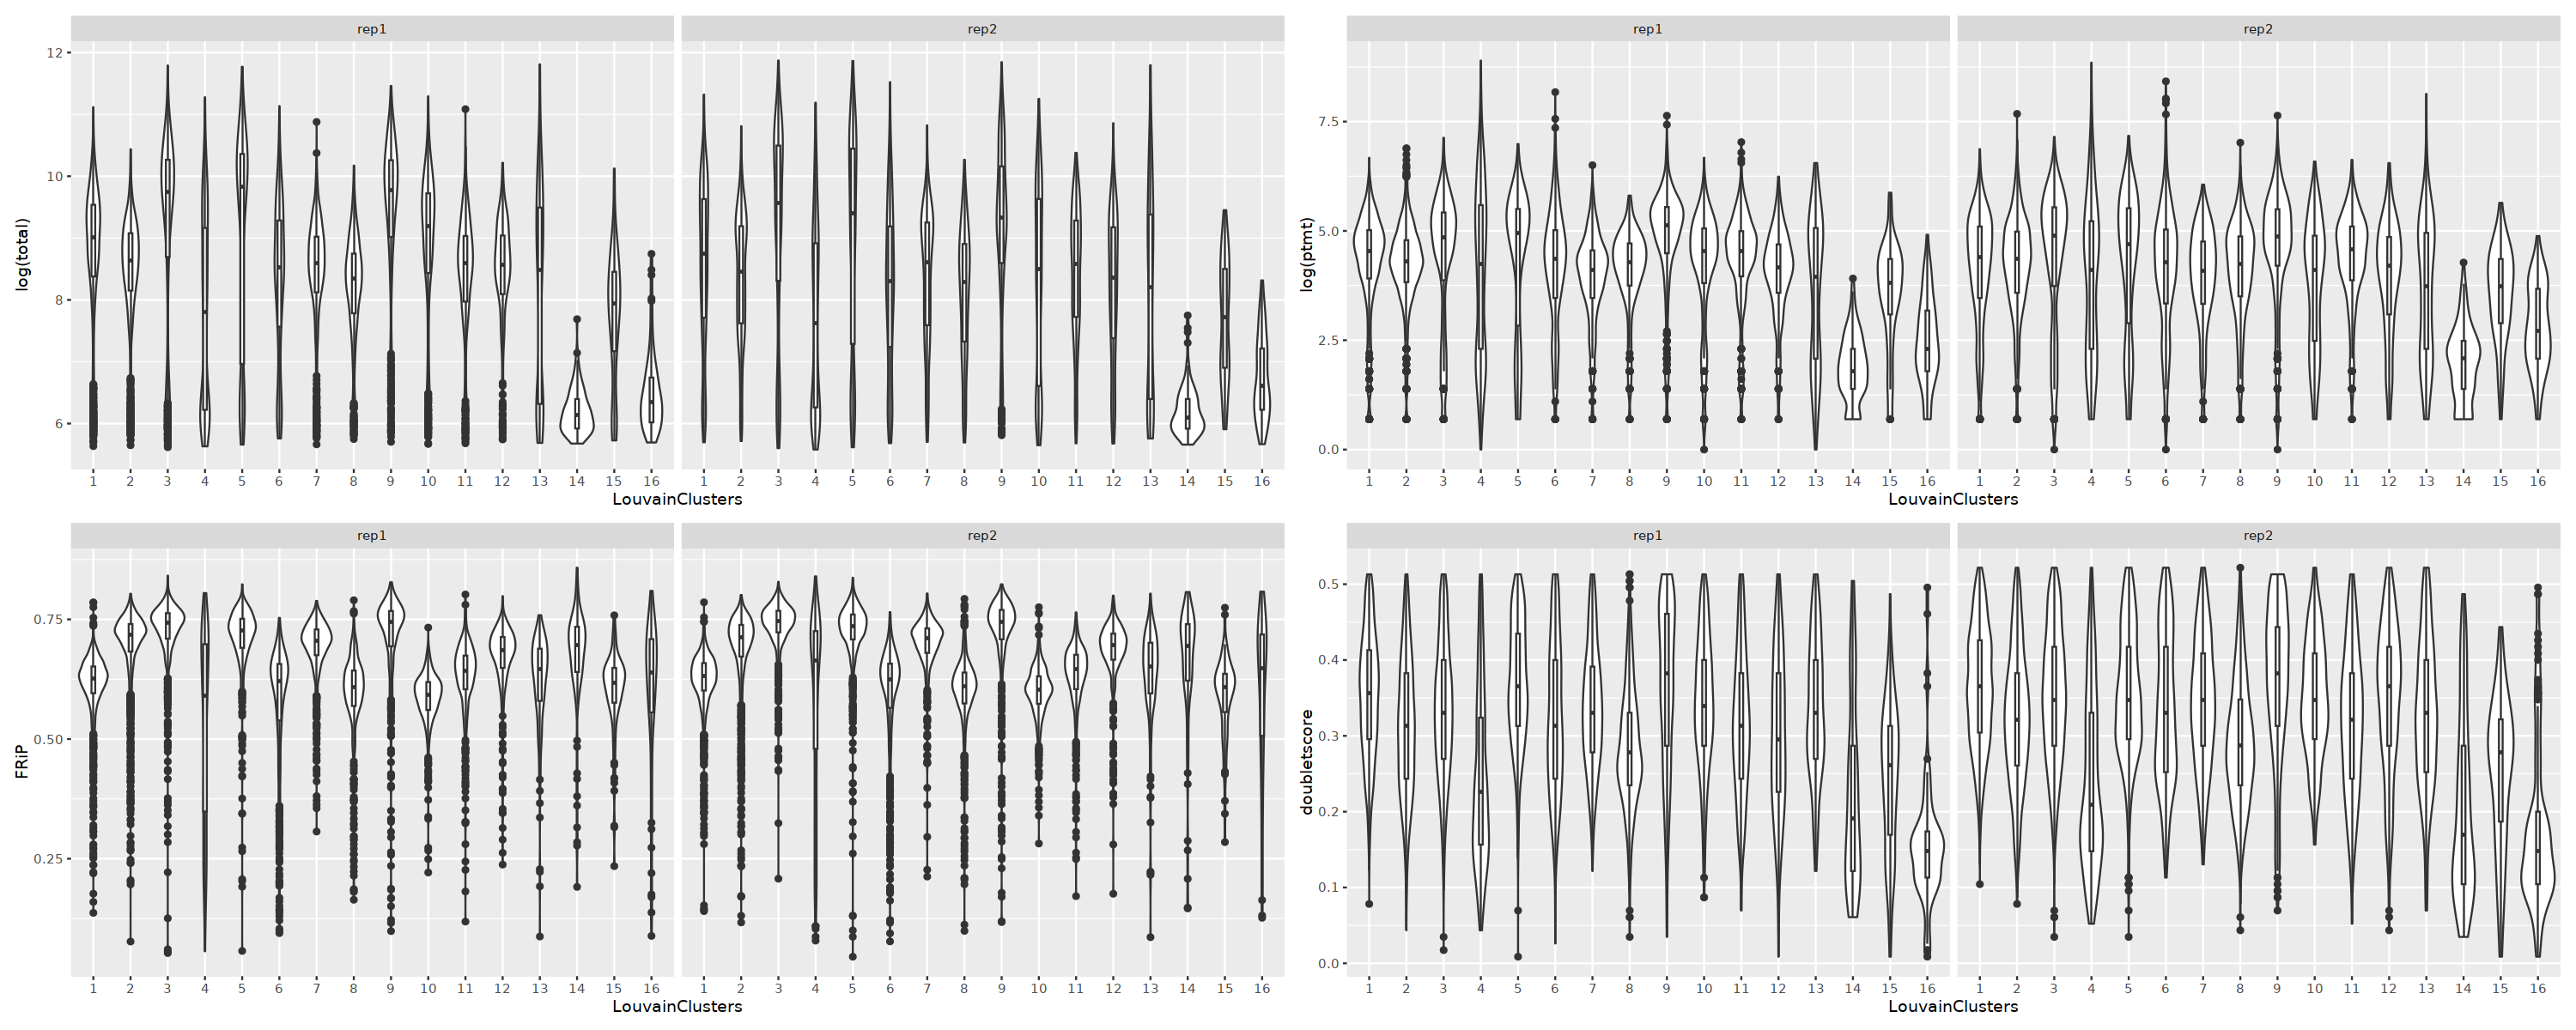

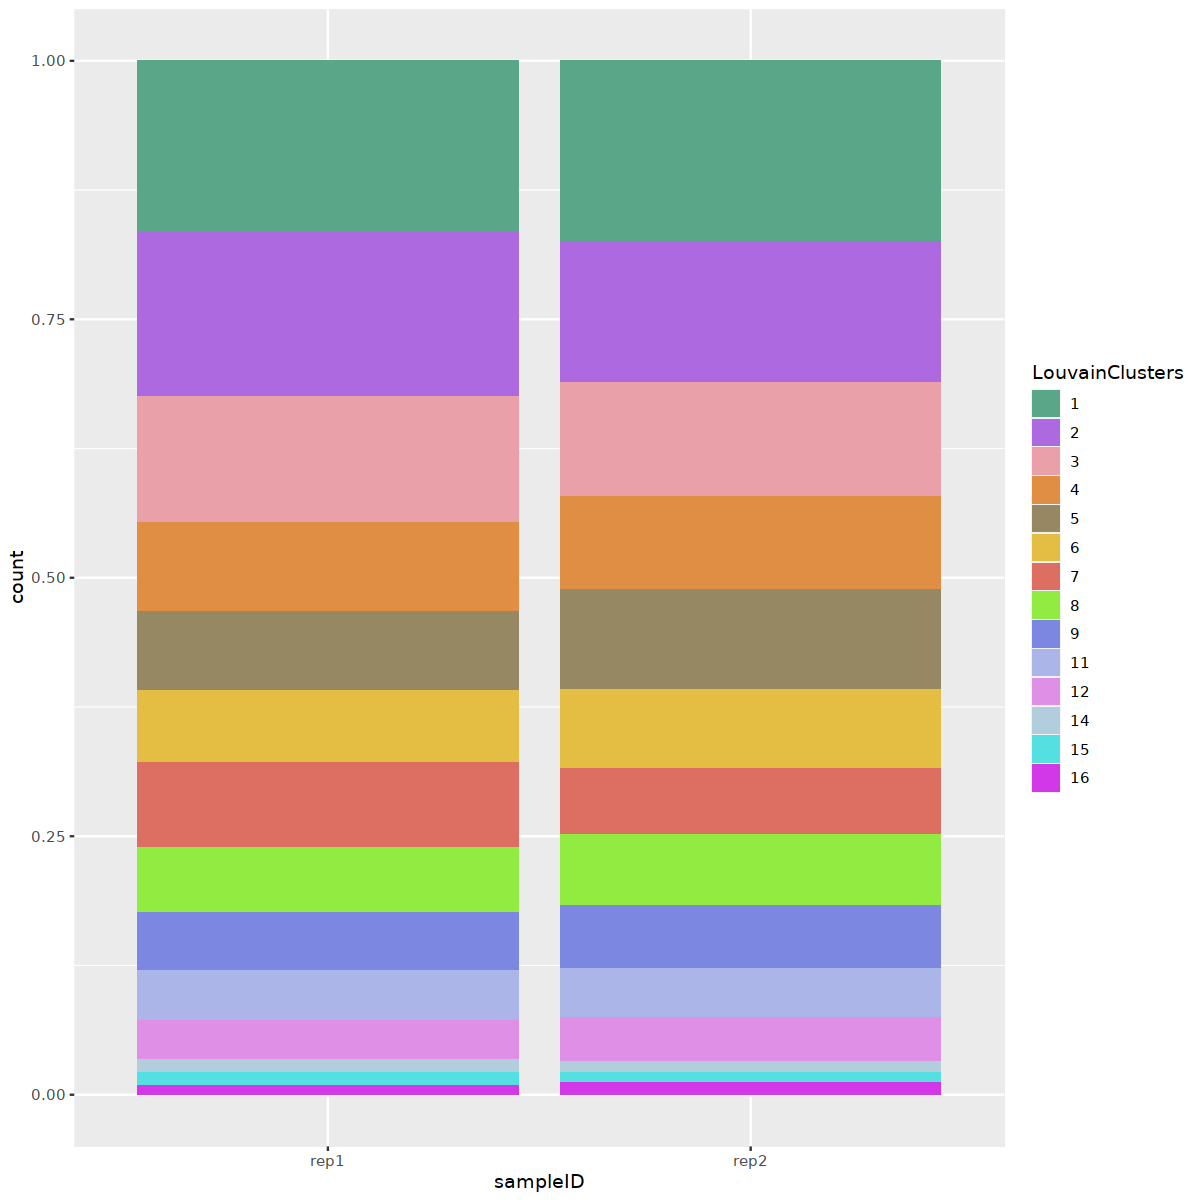

In [42]:
clusters_by_replicate <- cluster_plot  %>% 
    group_by(LouvainClusters, sampleID)  %>% 
    summarise(counts = n())

clusters_prop <- cluster_plot  %>% 
    group_by(LouvainClusters)  %>% 
    summarise(total_cluster = n())


clusters_full_joined <- full_join(clusters_by_replicate, clusters_prop, by = c("LouvainClusters"))  %>% 
    mutate(prop_cluster = counts/total_cluster)

clusters_full_joined

library(patchwork)

options(repr.plot.width=20, repr.plot.height=20)
total <- ggplot(cluster_plot ,aes(x = LouvainClusters, y = log(total))) + 
    geom_violin() + geom_boxplot(width=0.1) + facet_grid(.~sampleID)


ptmt <- ggplot(cluster_plot ,aes(x = LouvainClusters, y = log(ptmt))) + 
    geom_violin() + geom_boxplot(width=0.1) + facet_grid(.~sampleID)

tss <- ggplot(cluster_plot ,aes(x = LouvainClusters, y = tss)) + 
    geom_violin() + geom_boxplot(width=0.1) + facet_grid(.~sampleID)
 

frip <- ggplot(cluster_plot ,aes(x = LouvainClusters, y = FRiP)) + 
    geom_violin() + geom_boxplot(width=0.1) + facet_grid(.~sampleID)

doub <- ggplot(cluster_plot ,aes(x = LouvainClusters, y = doubletscore)) + 
    geom_violin() + geom_boxplot(width=0.1) + facet_grid(.~sampleID)
options(repr.plot.width=25, repr.plot.height=10)
(total + ptmt) / (frip + doub)

clusters_passing <- cluster_plot  %>% 
    dplyr::filter(LouvainClusters != "13")  %>% 
    dplyr::filter(LouvainClusters != "10")


options(repr.plot.width=10, repr.plot.height=10)
library(RColorBrewer)
library(tidyverse)
other <- randomcoloR::distinctColorPalette(k = 41)
#cell_converted_trible <- as_tibble(tfidf.obj.dob.filt.clusters$Clusters)
ggplot(clusters_passing,aes(x = sampleID, fill = LouvainClusters)) + 
    geom_bar(position = "fill") + scale_fill_manual(values=other)

In [45]:
#prefix <- "Sb_leaf.merged_replicates"
output_location <- "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/urochloa_fusc/clustering/"
paste0(data_path, prefix,".merged_clusters.sparse")
# output text files
nmf.meta <- tfidf.obj.dob.filt.clusters$Clusters
nmf.rd <- tfidf.obj.dob.filt.clusters$SVD

write.table(nmf.meta, file=paste0(output_location,prefix, ".SVD.full.metadata.txt"), quote=F, row.names=T, col.names=T, sep="\t")
write.table(nmf.rd, file=paste0(output_location, prefix, ".SVD.full.reduced_dimensions.txt"), quote=F, row.names=T, col.names=T, sep="\t")

[1] "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/urochloa_fusc/QC_output/Uf_leaf.merged_replicates.merged_clusters.sparse"

In [46]:
#Generate Sparse Matrix-
trip <- as.data.frame(summary(tfidf.obj.dob.filt.clusters$counts))
trip$i <- rownames(tfidf.obj.dob.filt.clusters$counts)[trip$i]
trip$j <- colnames(tfidf.obj.dob.filt.clusters$counts)[trip$j]

write.table(trip, file=paste0(output_location, prefix, ".SVD.sparse"), quote=F, row.names=T, col.names=T, sep="\t")

# Running  and Running Correlation on LCs...

In [7]:
library("presto")
run_presto <- function(meta_obj, 
                       meta_slot = "Clusters", 
                       cluster_name = "LouvainClusters", 
                       counts_raw="acr_counts_raw"){
    ### Pull the correct meta datafrom the Socrates Object
    sparse_matrix <- meta_obj[[counts_raw]]
    meta_data <- meta_obj[[meta_slot]]
    
    print(head(as_tibble(meta_data)))
        
    ### Read the Giant Sparse Matrix
    loaded_sparse_matric <- read_delim(sparse_matrix, delim='\t', 
                                       col_names = c("gene_name", "barcode", "accessability"), 
                                       col_types = "ccn")
    
    print(head(loaded_sparse_matric))
    combined_large_w_sparse <- loaded_sparse_matric  %>% 
        filter(gene_name != "Annotation")  %>% 
        dplyr::select(gene_name, barcode, accessability)  %>% 
        left_join(., meta_data, by = c("barcode" = "cellID"))  %>% 
        filter(is.na(!!sym(cluster_name)) != TRUE)  %>% 
        arrange(!!sym(cluster_name))
    
    #order <- combined_large_w_sparse[!!sym(cluster_name)]

    combined_large_w_sparse <- combined_large_w_sparse  %>% 
        dplyr::select(gene_name, barcode, accessability)  %>% 
        mutate(across(accessability, as.numeric))
    
    
    gene_names <- unique(combined_large_w_sparse$gene_name)
    barcodes <- unique(combined_large_w_sparse$barcode)

    combined_large_w_sparse$row <- match(combined_large_w_sparse$gene_name, gene_names)
    combined_large_w_sparse$col <- match(combined_large_w_sparse$barcode, barcodes)


    UIMatrix <- sparseMatrix(i = combined_large_w_sparse$row,
                         j = combined_large_w_sparse$col,
                         x = combined_large_w_sparse$accessability,
                         dimnames=list(gene_names, barcodes))

    print(head(tibble(barcode = unlist(UIMatrix@Dimnames[2]))))
    barcode_tibble <- tibble(barcode = unlist(UIMatrix@Dimnames[2])) %>% 
        left_join(., as_tibble(meta_data), by = c("barcode" = "cellID"))  %>% 
        filter(is.na(total) != TRUE)
    
    print(dim(barcode_tibble))
    print(dim(UIMatrix))
    
    clust_name <- c(cluster_name)
    garbbed_louv_order <- pull(barcode_tibble,!!sym(clust_name))

    sparse_matrix_test <- wilcoxauc(UIMatrix, garbbed_louv_order)
    
    meta_obj[["presto_marker"]] <- sparse_matrix_test
    
    return(meta_obj)
}

library(edgeR)
library(preprocessCore)
devtools::load_all('/home/jpm73279/software/preprocessCore')
library("edgeR")

marker_correlation <- function(meta_obj, 
                       meta_slot = "Clusters", 
                       cluster_name = "LouvainClusters", 
                       counts_raw="acr_counts_raw"){
   
    
    ### Pull the correct meta datafrom the Socrates Object
    sparse_matrix <- meta_obj[[counts_raw]]
    meta_data <- meta_obj[[meta_slot]]
    
    print(head(as_tibble(meta_data)))
        
    
    raw_cpm_counts_all_genes <- read_delim(sparse_matrix, delim="\t", col_names = c("gene_name", "barcode", "accessability")) %>%
        dplyr::mutate(cellID = barcode)  %>%
        dplyr::mutate(geneID = gene_name)

    merged_meta_cpm_information <- left_join(meta_data, raw_cpm_counts_all_genes, by = c("cellID"))  %>%
    #mutate(safe_cluster_name = str_c("Louvain_C", LouvainClusters, sep ="_"))  %>%
    #dplyr::select(-LouvainClusters)  %>%
        group_by(!!sym(cluster_name), geneID)  %>%
        summarise(counts = sum(accessability, na.rm = TRUE))

    ### Alt CPM Calc
    merged_meta_cpm_information_copied <- merged_meta_cpm_information
    catch <- merged_meta_cpm_information_copied  %>%
        group_by(!!sym(cluster_name)) %>%
        group_map(~(cpm(.x$counts, log = FALSE, group = .f)), .keep = TRUE)  %>%
        unlist()


    caught_values <- as_tibble(catch)

    see <- ungroup(merged_meta_cpm_information_copied)
    idk <- bind_cols(merged_meta_cpm_information_copied,caught_values)  
    print(head(idk))
    
    merged_meta_cpm_information_copied<- bind_cols(merged_meta_cpm_information_copied,caught_values)  %>% 
        ungroup()  %>% 
        dplyr::rename(grouped_CPM = value)  %>% 
        dplyr::group_by(!!sym(cluster_name)) %>%  
        dplyr::mutate(log_cpm  = log(grouped_CPM))


    #Apply quantile normalization
    merged_meta.quant_norm <- merged_meta_cpm_information_copied  %>% 
        group_by(!!sym(cluster_name))  %>% 
        group_map(~(preprocessCore::normalize.quantiles(data.matrix(.x$grouped_CPM), copy = FALSE)), .keep = TRUE)  %>% 
        unlist()

    zm.quantile_normalized <- as_tibble(merged_meta.quant_norm)  %>% 
        dplyr::rename("quant_norm_cpm" = value)


    merged_meta_cpm_information_copied <- bind_cols(merged_meta_cpm_information_copied, zm.quantile_normalized)

    cell_type_accessability <- merged_meta_cpm_information_copied  %>% 
        dplyr::ungroup()  %>% 
        dplyr::select(!!sym(cluster_name), geneID, quant_norm_cpm)  %>% 
        pivot_wider(names_from = !!sym(cluster_name), values_from = quant_norm_cpm, values_fill = 0)
    
    meta_obj[["corr_matrix"]] <- cell_type_accessability
    
    return(meta_obj)
}


Loading required package: limma


Attaching package: 'limma'


The following object is masked from 'package:BiocGenerics':

    plotMA


ℹ Loading preprocessCore


In [2]:
library("here")
library(devtools)
library(Seurat)

load_all('/home/jpm73279/Socrates')

reference_genome_path <- "/home/jpm73279/genome_downloads/Ufusca/v1.1/"
#analysis_path <- "/scratch/jpm73279/comparative_single_cell/01.alignments_annotations/Urochloa_fusca/"
analysis_path <- "/scratch/jpm73279/comparative_single_cell/01.alignments_annotations/urochlea_fusca.snake/03.bed_files_merged/"
uro_mergeed <- paste0(analysis_path, "urochlea_fusca.filter.mpq_10.rmdup.unique.sorted.bed")

# set-up arguments

#ann <- "Zm-B73-REFERENCE-NAM-5.0_Zm00001eb.1.nuclear.gff3"
#chr <- "Zm-B73-REFERENCE-NAM-5.0.chrom.size"
#pre <- "Sb.Leaf_rep2"
#output <- as.character(args[5])

ann <- paste0(reference_genome_path,"annotation/Ufusca_669_v1.1.gene.gff3")
chr <- paste0(reference_genome_path,"assembly/Ufusca_669_v1.0.Pt.sizes")
pre <- "Uro_fusca.sciATAC_merged"

Uro_P1.leaf <- loadBEDandGenomeData(uro_mergeed, ann, chr)

ℹ Loading Socrates
Warning message:
"replacing previous import 'scales::viridis_pal' by 'viridis::viridis_pal' when loading 'Socrates'"
Running pre-check on input files and executable paths ...

BED file path = /scratch/jpm73279/comparative_single_cell/01.alignments_annotations/urochlea_fusca.snake/03.bed_files_merged/urochlea_fusca.filter.mpq_10.rmdup.unique.sorted.bed ... ok

GFF file path = /home/jpm73279/genome_downloads/Ufusca/v1.1/annotation/Ufusca_669_v1.1.gene.gff3 ... ok

Chromosome sizes file path = /home/jpm73279/genome_downloads/Ufusca/v1.1/assembly/Ufusca_669_v1.0.Pt.sizes ... ok

Macs2 is installed .... ok

 - loading data (this may take obj while for big BED files) ...

 - finished loading data



In [3]:
library(tidyverse)
uf_meta_data <- read_delim("/scratch/jpm73279/comparative_single_cell/02.QC_clustering/urochloa_fusc/clustering/Uf_leaf.merged_replicates.SVD.full.metadata.txt", skip = 1,
                           col_names =  c("row_n",'cellID', 'total', 'tss', 'acrs', 'ptmt', 'nSites', 'log10nSites', 'pTSS', 'FRiP', 'pOrg', 'tss_z', 'acr_z', 'sites_z', 'qc_check', 'background', 'cellbulk', 'is_cell', 'sampleID', 'umap1', 'umap2', 'doubletscore', 'd.type', 'LouvainClusters'))
uf_gene_counts <- "/scratch/jpm73279/comparative_single_cell/04.marker_annotation/urochloa_fusca/acc_metrics_leaf_clustering/urochloa_fusca.gene_body_acc_leaf_clustering.counts.txt" 

── Attaching core tidyverse packages ─────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.1          ✔ readr     2.1.4     
✔ forcats   1.0.0.9000     ✔ stringr   1.5.0     
✔ lubridate 1.9.2          ✔ tibble    3.2.1     
✔ purrr     1.0.1          ✔ tidyr     1.3.0     
── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ lubridate::%within%() masks IRanges::%within%()
✖ purrr::accumulate()   masks foreach::accumulate()
✖ readr::col_factor()   masks Socrates::col_factor(), scales::col_factor()
✖ dplyr::collapse()     masks IRanges::collapse()
✖ dplyr::combine()      masks Biobase::combine(), BiocGenerics::combine()
✖ dplyr::count()        masks matrixStats::count()
✖ dplyr::desc()         masks IRanges::desc()
✖ purrr::discard()      masks Socrates::discard(), scales::discard()
✖ tidyr::expand()       masks

In [9]:
Uro_P1.leaf$meta <- uf_meta_data
Uro_P1.leaf$acr_counts_raw <- uf_gene_counts
uf_meta_data$row_n <- uf_meta_data$cellID

library(presto)
Uro_P1.leaf.presto <- run_presto(Uro_P1.leaf,
           meta_slot = "meta",
           counts_raw = "acr_counts_raw",
           cluster_name = "LouvainClusters")

marker_list_uf_file <- "/home/jpm73279/genome_downloads/Ufusca/markers_2023-04-18/Uf.leaf_all_combined_markers.visualzied.bed"
marker_list_uf <- read_delim(marker_list_uf_file, delim='\t', 
                                       col_names = c("chr", "start", "stop", "geneID", "gene_name", "cell_type", "tissue"))

head(marker_list_uf)

# A tibble: 6 × 24
  row_n   cellID  total   tss  acrs  ptmt nSites log10nSites  pTSS  FRiP    pOrg
  <chr>   <chr>   <dbl> <dbl> <dbl> <dbl>  <dbl>       <dbl> <dbl> <dbl>   <dbl>
1 BC:Z:A… BC:Z:… 124930 52679 52003  1031  52762        4.72 0.422 0.416 0.00825
2 BC:Z:G… BC:Z:…  76720 25430  9900  1280  42124        4.62 0.331 0.129 0.0167 
3 BC:Z:T… BC:Z:… 134532 74088 81810   413  38929        4.59 0.551 0.608 0.00307
4 BC:Z:G… BC:Z:…  79064 28644 19632  3645  38769        4.59 0.362 0.248 0.0461 
5 BC:Z:C… BC:Z:… 100369 50764 52117   516  38454        4.58 0.506 0.519 0.00514
6 BC:Z:A… BC:Z:…  89967 45551 42667   563  37093        4.57 0.506 0.474 0.00626
# ℹ 13 more variables: tss_z <dbl>, acr_z <dbl>, sites_z <dbl>, qc_check <dbl>,
#   background <dbl>, cellbulk <dbl>, is_cell <dbl>, sampleID <chr>,
#   umap1 <dbl>, umap2 <dbl>, doubletscore <dbl>, d.type <chr>,
#   LouvainClusters <dbl>
# A tibble: 6 × 3
  gene_name           barcode                                      accessabi

Rows: 168 Columns: 6
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (6): chr, start, stop, geneID, gene_name, cell_type

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


chr   start    stop     geneID             
1 chr   star     end      geneID             
2 Chr03 29932900 29935524 Urofu.3G374800.v1.1
3 Chr03 29892908 29895399 Urofu.3G374700.v1.1
4 Chr06 18929130 18934187 Urofu.6G138800.v1.1
5 Chr04 27075877 27077289 Urofu.4G278800.v1.1
6 Chr05 1028057  1032932  Urofu.5G019400.v1.1
  gene_name                                                             
1 name                                                                  
2 sweet13a_ortho_count_1__sweet13b_ortho_count_1__sweet13c_ortho_count_1
3 sweet13a_ortho_count_2__sweet13b_ortho_count_2__sweet13c_ortho_count_2
4 kan1                                                                  
5 BAF1                                                                  
6 tru1_v4v5count_1                                                      
  cell_type                                                          
1 type                                                               
2 abaxial_bundle_sheath.phloem_parenchyma                            
3 abaxial_bundle_sheath.phloem_parenchyma                            
4 abaxial_domains                                                    
5 axillary_meristem                                                  
6 axillary_meristem_lateral_primordia,basal_comparment_lateral_organs

In [12]:
grabbed_top_marker_per_cluster <- top_markers(Uro_P1.leaf.presto$presto_marker, 200)

represented_marker_lst <- list()
for (i in unique(Uro_P1.leaf.presto$meta$LouvainClusters)) {
    
    #make_set <- setNames("geneID",i) 
    
    LC_top_genes <- grabbed_top_marker_per_cluster[, c("rank", i)]
    LC_top_genes <- dplyr::rename(LC_top_genes, geneID = as.character(i))
    
    markers_present_in_presto <- left_join(LC_top_genes, 
                                           marker_list_uf, by = c("geneID"))  %>% 
    dplyr::filter(is.na(chr) != TRUE)  %>% 
    dplyr::select(rank, geneID, chr, start, stop, gene_name, cell_type) %>% 
    dplyr::mutate(LC_value = str_c("LC", as.character(i),  sep ="_")) 
    
    represented_marker_lst[[i]] <- markers_present_in_presto
}
                 
represented_marker_lst

gathered_markers <- bind_rows(represented_marker_lst)  %>% 
    arrange(LC_value, rank)

gathered_markers

[[1]]
# A tibble: 4 × 8
   rank geneID              chr   start    stop     gene_name cell_type LC_value
  <int> <chr>               <chr> <chr>    <chr>    <chr>     <chr>     <chr>   
1     2 Urofu.2G217100.v1.1 Chr02 23850265 23856855 gl1       epidermis LC_1    
2    16 Urofu.3G253900.v1.1 Chr03 14942441 14945092 gpat11__… epidermi… LC_1    
3    67 Urofu.9G330400.v1.1 Chr09 28326885 28333607 ocl4      protoder… LC_1    
4   184 Urofu.6G149300.v1.1 Chr06 19793796 19801270 ccr1      vascular… LC_1    

[[2]]
# A tibble: 7 × 8
   rank geneID              chr   start    stop     gene_name cell_type LC_value
  <int> <chr>               <chr> <chr>    <chr>    <chr>     <chr>     <chr>   
1     1 Urofu.4G117600.v1.1 Chr04 8821800  8838687  PEPC_1_o… mesophyll LC_2    
2     2 Urofu.3G289200.v1.1 Chr03 17296951 17311100 PPDK_1__… mesophyll LC_2    
3     3 Urofu.4G117200.v1.1 Chr04 8747411  8752435  PEPC_1_o… mesophyll LC_2    
4    21 Urofu.5G154300.v1.1 Chr05 8647931  8653612  AspAT_1_… bundle_s… LC_2    
5    94 Urofu.6G241800.v1.1 Chr06 25774055 25777907 NADP-MDH… mesophyll LC_2    
6   111 Urofu.3G312800.v1.1 Chr03 19426343 19426977 ssu2_ort… bundle_s… LC_2    
7   198 Urofu.6G101400.v1.1 Chr06 14680381 14685296 PPT_3__P… mesophyll LC_2    

[[3]]
# A tibble: 8 × 8
   rank geneID              chr   start    stop     gene_name cell_type LC_value
  <int> <chr>               <chr> <chr>    <chr>    <chr>     <chr>     <chr>   
1     5 Urofu.9G211000.v1.1 Chr09 12687742 12693386 NAD-ME_1… bundle_s… LC_3    
2    23 Urofu.9G210200.v1.1 Chr09 12649354 12658527 NAD-ME_1… bundle_s… LC_3    
3    43 Urofu.9G210700.v1.1 Chr09 12669925 12675102 NAD-ME_1… bundle_s… LC_3    
4    58 Urofu.9G235100.v1.1 Chr09 14368081 14372844 NADP-MDH… mesophyll LC_3    
5   137 Urofu.3G093000.v1.1 Chr03 5104696  5109172  PPA2_1    mesophyll LC_3    
6   138 Urofu.3G312800.v1.1 Chr03 19426343 19426977 ssu2_ort… bundle_s… LC_3    
7   139 Urofu.5G154300.v1.1 Chr05 8647931  8653612  AspAT_1_… bundle_s… LC_3    
8   168 Urofu.3G289200.v1.1 Chr03 17296951 17311100 PPDK_1__… mesophyll LC_3    

[[4]]
# A tibble: 0 × 8
# ℹ 8 variables: rank <int>, geneID <chr>, chr <chr>, start <chr>, stop <chr>,
#   gene_name <chr>, cell_type <chr>, LC_value <chr>

[[5]]
# A tibble: 2 × 8
   rank geneID              chr   start    stop     gene_name cell_type LC_value
  <int> <chr>               <chr> <chr>    <chr>    <chr>     <chr>     <chr>   
1    71 Urofu.9G210200.v1.1 Chr09 12649354 12658527 NAD-ME_1… bundle_s… LC_5    
2   120 Urofu.9G211000.v1.1 Chr09 12687742 12693386 NAD-ME_1… bundle_s… LC_5    

[[6]]
# A tibble: 6 × 8
   rank geneID              chr   start    stop     gene_name cell_type LC_value
  <int> <chr>               <chr> <chr>    <chr>    <chr>     <chr>     <chr>   
1     3 Urofu.3G253900.v1.1 Chr03 14942441 14945092 gpat11__… epidermi… LC_6    
2     6 Urofu.2G217100.v1.1 Chr02 23850265 23856855 gl1       epidermis LC_6    
3    21 Urofu.6G149300.v1.1 Chr06 19793796 19801270 ccr1      vascular… LC_6    
4    25 Urofu.6G004000.v1.1 Chr06 240831   243882   snd1__ns… xylem     LC_6    
5    83 Urofu.9G330400.v1.1 Chr09 28326885 28333607 ocl4      protoder… LC_6    
6   186 Urofu.7G115900.v1.1 Chr07 17193293 17193985 acl1      bullifor… LC_6    

[[7]]
# A tibble: 4 × 8
   rank geneID              chr   start    stop     gene_name cell_type LC_value
  <int> <chr>               <chr> <chr>    <chr>    <chr>     <chr>     <chr>   
1     1 Urofu.4G117600.v1.1 Chr04 8821800  8838687  PEPC_1_o… mesophyll LC_7    
2     9 Urofu.4G117200.v1.1 Chr04 8747411  8752435  PEPC_1_o… mesophyll LC_7    
3    58 Urofu.1G059600.v1.1 Chr01 3840007  3845082  bm5       vascular… LC_7    
4   126 Urofu.3G289200.v1.1 Chr03 17296951 17311100 PPDK_1__… mesophyll LC_7    

[[8]]
# A tibble: 3 × 8
   rank geneID              chr   start    stop     gene_name cell_type LC_value
  <int> <chr>               <chr> <chr>    <chr>    <chr>     <chr>     <chr>   
1     3 Urofu.9G553700.v

rank geneID              chr   start    stop    
1    2  Urofu.2G217100.v1.1 Chr02 23850265 23856855
2   16  Urofu.3G253900.v1.1 Chr03 14942441 14945092
3   67  Urofu.9G330400.v1.1 Chr09 28326885 28333607
4  184  Urofu.6G149300.v1.1 Chr06 19793796 19801270
5    3  Urofu.2G217100.v1.1 Chr02 23850265 23856855
6   80  Urofu.9G238000.v1.1 Chr09 14688239 14692395
7  184  Urofu.3G253900.v1.1 Chr03 14942441 14945092
8    8  Urofu.6G149300.v1.1 Chr06 19793796 19801270
9   26  Urofu.3G374700.v1.1 Chr03 29892908 29895399
10 107  Urofu.9G379000.v1.1 Chr09 32133821 32135711
11 139  Urofu.3G374800.v1.1 Chr03 29932900 29935524
12 140  Urofu.2G387400.v1.1 Chr02 34800116 34804040
13   2  Urofu.4G117600.v1.1 Chr04 8821800  8838687 
14  17  Urofu.4G117200.v1.1 Chr04 8747411  8752435 
15  20  Urofu.7G239500.v1.1 Chr07 24840040 24846138
16  64  Urofu.7G197300.v1.1 Chr07 22236736 22239131
17 131  Urofu.7G305100.v1.1 Chr07 28550305 28551522
18  78  Urofu.9G489700.v1.1 Chr09 39453199 39458159
19 109  Urofu.2G144100.v1.1 Chr02 13482813 13485651
20 123  Urofu.4G188900.v1.1 Chr04 21324471 21330970
21 194  Urofu.3G277000.v1.1 Chr03 16321378 16324498
22   1  Urofu.4G117600.v1.1 Chr04 8821800  8838687 
23   2  Urofu.3G289200.v1.1 Chr03 17296951 17311100
24   3  Urofu.4G117200.v1.1 Chr04 8747411  8752435 
25  21  Urofu.5G154300.v1.1 Chr05 8647931  8653612 
26  94  Urofu.6G241800.v1.1 Chr06 25774055 25777907
27 111  Urofu.3G312800.v1.1 Chr03 19426343 19426977
28 198  Urofu.6G101400.v1.1 Chr06 14680381 14685296
29   5  Urofu.9G211000.v1.1 Chr09 12687742 12693386
30  23  Urofu.9G210200.v1.1 Chr09 12649354 12658527
31  43  Urofu.9G210700.v1.1 Chr09 12669925 12675102
32  58  Urofu.9G235100.v1.1 Chr09 14368081 14372844
33 137  Urofu.3G093000.v1.1 Chr03 5104696  5109172 
34 138  Urofu.3G312800.v1.1 Chr03 19426343 19426977
35 139  Urofu.5G154300.v1.1 Chr05 8647931  8653612 
36 168  Urofu.3G289200.v1.1 Chr03 17296951 17311100
37  71  Urofu.9G210200.v1.1 Chr09 12649354 12658527
38 120  Urofu.9G211000.v1.1 Chr09 12687742 12693386
39   3  Urofu.3G253900.v1.1 Chr03 14942441 14945092
40   6  Urofu.2G217100.v1.1 Chr02 23850265 23856855
41  21  Urofu.6G149300.v1.1 Chr06 19793796 19801270
42  25  Urofu.6G004000.v1.1 Chr06 240831   243882  
43  83  Urofu.9G330400.v1.1 Chr09 28326885 28333607
44 186  Urofu.7G115900.v1.1 Chr07 17193293 17193985
45   1  Urofu.4G117600.v1.1 Chr04 8821800  8838687 
46   9  Urofu.4G117200.v1.1 Chr04 8747411  8752435 
47  58  Urofu.1G059600.v1.1 Chr01 3840007  3845082 
48 126  Urofu.3G289200.v1.1 Chr03 17296951 17311100
49   3  Urofu.9G553700.v1.1 Chr09 43382634 43388683
50 112  Urofu.9G480900.v1.1 Chr09 38932041 38937498
51 163  Urofu.3G277900.v1.1 Chr03 16372777 16376550
52  12  Urofu.9G211000.v1.1 Chr09 12687742 12693386
53  36  Urofu.9G235100.v1.1 Chr09 14368081 14372844
54  42  Urofu.9G210200.v1.1 Chr09 12649354 12658527
55  56  Urofu.9G210700.v1.1 Chr09 12669925 12675102
56 116  Urofu.3G312800.v1.1 Chr03 19426343 19426977
   gene_name                                                             
1  gl1                                                                   
2  gpat11__gpat12                                                        
3  ocl4                                                                  
4  ccr1                                                                  
5  gl1                                                                   
6  ad1                                                                   
7  gpat11__gpat12                                                        
8  ccr1                                                                  
9  sweet13a_ortho_count_2__sweet13b_ortho_count_2__sweet13c_ortho_count_2
10 shr1_v4v5count_1                                                      
11 sweet13a_ortho_count_1__sweet13b_ortho_count_1__sweet13c_ortho_count_1
12 shr2h__shr2                                                           
13 PEPC_1_ortho_count_2__PEPC_2_ortho_count_2                            
14 

In [13]:
de_novo_marker_list_uf_file <- "/home/jpm73279/genome_downloads/Ufusca/markers_2023-04-18/Uf.de_novo_orthos.markers.visualized.bed"
de_novo_marker_list_uf <- read_delim(de_novo_marker_list_uf_file, delim='\t', 
                                       col_names = c("chr", "start", "stop", "geneID", "gene_name", "cell_type", "tissue"))



represented_marker_lst <- list()
for (i in unique(Uro_P1.leaf.presto$meta$LouvainClusters)) {
    
    #make_set <- setNames("geneID",i) 
    
    LC_top_genes <- grabbed_top_marker_per_cluster[, c("rank", i)]
    LC_top_genes <- dplyr::rename(LC_top_genes, geneID = as.character(i))
    
    markers_present_in_presto <- left_join(LC_top_genes, 
                                           de_novo_marker_list_uf, by = c("geneID"))  %>% 
    dplyr::filter(is.na(chr) != TRUE)  %>% 
    dplyr::select(rank, geneID, chr, start, stop, gene_name, cell_type) %>% 
    dplyr::mutate(LC_value = str_c("LC", as.character(i),  sep ="_")) 
    
    represented_marker_lst[[i]] <- markers_present_in_presto
}
                 
represented_marker_lst

gathered_markers <- bind_rows(represented_marker_lst)  %>% 
    arrange(LC_value, rank)

gathered_markers

Rows: 373 Columns: 6
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (6): chr, start, stop, geneID, gene_name, cell_type

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[[1]]
# A tibble: 17 × 8
    rank geneID              chr   start    stop    gene_name cell_type LC_value
   <int> <chr>               <chr> <chr>    <chr>   <chr>     <chr>     <chr>   
 1     1 Urofu.9G538000.v1.1 Chr09 42511556 425130… Zm00001e… epidermis LC_1    
 2     2 Urofu.2G217100.v1.1 Chr02 23850265 238568… Zm00001e… epidermis LC_1    
 3     9 Urofu.5G247900.v1.1 Chr05 14289637 142965… Zm00001e… epidermis LC_1    
 4    11 Urofu.5G086100.v1.1 Chr05 4822609  4827919 Zm00001e… epidermis LC_1    
 5    16 Urofu.3G253900.v1.1 Chr03 14942441 149450… Zm00001e… epidermis LC_1    
 6    31 Urofu.3G387600.v1.1 Chr03 31757898 317601… Zm00001e… epidermis LC_1    
 7    34 Urofu.2G132300.v1.1 Chr02 10988179 109891… Zm00001e… epidermis LC_1    
 8    58 Urofu.8G170600.v1.1 Chr08 24657002 246610… Zm00001e… epidermis LC_1    
 9    62 Urofu.5G178200.v1.1 Chr05 10053948 100562… Zm00001e… epidermis LC_1    
10   113 Urofu.9G050800.v1.1 Chr09 2576318  2578763 Zm00001e… mesophyll LC_1    
11   117 Urofu.2G109100.v1.1 Chr02 8820581  8826544 Zm00001e… epidermis LC_1    
12   130 Urofu.9G547100.v1.1 Chr09 43015202 430195… Zm00001e… epidermis LC_1    
13   132 Urofu.7G053300.v1.1 Chr07 10246507 102483… Zm00001e… epidermis LC_1    
14   145 Urofu.2G193600.v1.1 Chr02 21969677 219711… Zm00001e… protoderm LC_1    
15   153 Urofu.5G214600.v1.1 Chr05 12077955 120838… Zm00001e… epidermis LC_1    
16   169 Urofu.9G439300.v1.1 Chr09 36281907 362875… Zm00001e… epidermis LC_1    
17   184 Urofu.6G149300.v1.1 Chr06 19793796 198012… Zm00001e… bundle_s… LC_1    

[[2]]
# A tibble: 19 × 8
    rank geneID              chr   start    stop    gene_name cell_type LC_value
   <int> <chr>               <chr> <chr>    <chr>   <chr>     <chr>     <chr>   
 1     5 Urofu.6G011100.v1.1 Chr06 708292   711428  Zm00001e… mesophyll LC_2    
 2    13 Urofu.1G405000.v1.1 Chr01 34968902 349702… Zm00001e… mesophyll LC_2    
 3    17 Urofu.5G063600.v1.1 Chr05 3598171  3602807 Zm00001e… mesophyll LC_2    
 4    35 Urofu.9G585500.v1.1 Chr09 45216670 452197… Zm00001e… mesophyll LC_2    
 5    47 Urofu.7G273000.v1.1 Chr07 26805977 268069… Zm00001e… mesophyll LC_2    
 6    59 Urofu.2G297700.v1.1 Chr02 29219320 292217… Zm00001e… mesophyll LC_2    
 7    64 Urofu.3G280500.v1.1 Chr03 16627707 166314… Zm00001e… mesophyll LC_2    
 8    66 Urofu.9G064800.v1.1 Chr09 3357067  3357759 Zm00001e… mesophyll LC_2    
 9    68 Urofu.6G162000.v1.1 Chr06 20814223 208152… Zm00001e… mesophyll LC_2    
10    72 Urofu.5G333000.v1.1 Chr05 25647649 256499… Zm00001e… companio… LC_2    
11    76 Urofu.5G459300.v1.1 Chr05 36030283 360354… Zm00001e… mesophyll LC_2    
12    80 Urofu.6G116600.v1.1 Chr06 16561038 165649… Zm00001e… mesophyll LC_2    
13    94 Urofu.6G241800.v1.1 Chr06 25774055 257779… Zm00001e… mesophyll LC_2    
14   111 Urofu.3G312800.v1.1 Chr03 19426343 194269… Zm00001e… bundle_s… LC_2    
15   120 Urofu.1G347200.v1.1 Chr01 31613970 316184… Zm00001e… mesophyll LC_2    
16   128 Urofu.9G510400.v1.1 Chr09 40889130 408911… Zm00001e… mesophyll LC_2    
17   138 Urofu.1G130000.v1.1 Chr01 9836864  9841852 Zm00001e… mesophyll LC_2    
18   185 Urofu.6G173800.v1.1 Chr06 21613898 216179… Zm00001e… mesophyll LC_2    
19   194 Urofu.9G186200.v1.1 Chr09 11110353 111145… Zm00001e… mesophyll LC_2    

[[3]]
# A tibble: 16 × 8
    rank geneID              chr   start    stop    gene_name cell_type LC_value
   <int> <chr>               <chr> <chr>    <chr>   <chr>     <chr>     <chr>   
 1     8 Urofu.5G194400.v1.1 Chr05 10878701 108860… Zm00001e… bundle_s… LC_3    
 2    11 Urofu.1G125700.v1.1 Chr01 9372589  9376290 Zm00001e… bundle_s… LC_3    
 3    19 Urofu.6G144700.v1.1 Chr06 19472505 194753… Zm00001e… companio… LC_3    
 4    22 Urofu.5G020300.v1.1 Chr05 1065476  1068538 Zm00001e… mesophyll LC_3    
 5    29 Urofu.7G014300.v1.1 Chr07 1742505  1751156 Zm00001e… mesophyll LC_3    
 6    51 Urofu.8G060100.v1.1 Chr08 4271437  4274093 Zm00001e… bundle_s… LC_3    
 7   107 Urofu.4G085300.v1.1 Chr04 

rank geneID              chr   start    stop    
1     1  Urofu.9G538000.v1.1 Chr09 42511556 42513056
2     2  Urofu.2G217100.v1.1 Chr02 23850265 23856855
3     9  Urofu.5G247900.v1.1 Chr05 14289637 14296580
4    11  Urofu.5G086100.v1.1 Chr05 4822609  4827919 
5    16  Urofu.3G253900.v1.1 Chr03 14942441 14945092
6    31  Urofu.3G387600.v1.1 Chr03 31757898 31760161
7    34  Urofu.2G132300.v1.1 Chr02 10988179 10989168
8    58  Urofu.8G170600.v1.1 Chr08 24657002 24661030
9    62  Urofu.5G178200.v1.1 Chr05 10053948 10056209
10  113  Urofu.9G050800.v1.1 Chr09 2576318  2578763 
11  117  Urofu.2G109100.v1.1 Chr02 8820581  8826544 
12  130  Urofu.9G547100.v1.1 Chr09 43015202 43019523
13  132  Urofu.7G053300.v1.1 Chr07 10246507 10248326
14  145  Urofu.2G193600.v1.1 Chr02 21969677 21971101
15  153  Urofu.5G214600.v1.1 Chr05 12077955 12083870
16  169  Urofu.9G439300.v1.1 Chr09 36281907 36287509
17  184  Urofu.6G149300.v1.1 Chr06 19793796 19801270
18    3  Urofu.2G217100.v1.1 Chr02 23850265 23856855
19    6  Urofu.9G538000.v1.1 Chr09 42511556 42513056
20   14  Urofu.5G247900.v1.1 Chr05 14289637 14296580
21   31  Urofu.8G170600.v1.1 Chr08 24657002 24661030
22   37  Urofu.5G086100.v1.1 Chr05 4822609  4827919 
23   46  Urofu.3G387600.v1.1 Chr03 31757898 31760161
24   47  Urofu.9G547100.v1.1 Chr09 43015202 43019523
25   80  Urofu.9G238000.v1.1 Chr09 14688239 14692395
26   84  Urofu.2G193600.v1.1 Chr02 21969677 21971101
27  181  Urofu.9G050800.v1.1 Chr09 2576318  2578763 
28  184  Urofu.3G253900.v1.1 Chr03 14942441 14945092
29    7  Urofu.8G048800.v1.1 Chr08 3207964  3212732 
30    8  Urofu.6G149300.v1.1 Chr06 19793796 19801270
⋮   ⋮    ⋮                   ⋮     ⋮        ⋮       
151  60  Urofu.5G280500.v1.1 Chr05 16694122 16697653
152  61  Urofu.3G174200.v1.1 Chr03 10182454 10189513
153  65  Urofu.2G410600.v1.1 Chr02 36032476 36033641
154  72  Urofu.3G165000.v1.1 Chr03 9668498  9668888 
155  85  Urofu.9G553800.v1.1 Chr09 43388825 43390302
156  89  Urofu.9G343200.v1.1 Chr09 29352101 29353631
157  94  Urofu.7G203000.v1.1 Chr07 22610506 22615839
158 110  Urofu.5G419900.v1.1 Chr05 33771054 33777461
159 125  Urofu.1G360700.v1.1 Chr01 32544677 32548489
160 128  Urofu.9G087900.v1.1 Chr09 4729903  4734460 
161 138  Urofu.3G223400.v1.1 Chr03 13184639 13185883
162 160  Urofu.1G344300.v1.1 Chr01 31398923 31402507
163 175  Urofu.3G102400.v1.1 Chr03 5726380  5728772 
164 177  Urofu.6G138500.v1.1 Chr06 18886510 18888725
165 184  Urofu.3G418800.v1.1 Chr03 34258613 34261125
166 186  Urofu.2G204800.v1.1 Chr02 22921603 22922030
167   7  Urofu.5G194400.v1.1 Chr05 10878701 10886012
168  14  Urofu.1G125700.v1.1 Chr01 9372589  9376290 
169  23  Urofu.7G014300.v1.1 Chr07 1742505  1751156 
170  39  Urofu.6G144700.v1.1 Chr06 19472505 19475351
171  55  Urofu.8G060100.v1.1 Chr08 4271437  4274093 
172  58  Urofu.5G020300.v1.1 Chr05 1065476  1068538 
173  59  Urofu.2G366800.v1.1 Chr02 33590115 33591666
174  60  Urofu.3G362800.v1.1 Chr03 28095678 28097767
175  97  Urofu.3G463700.v1.1 Chr03 37580517 37584067
176 107  Urofu.9G533900.v1.1 Chr09 42285023 42285551
177 116  Urofu.3G312800.v1.1 Chr03 19426343 19426977
178 122  Urofu.3G051000.v1.1 Chr03 2665981  2668585 
179 145  Urofu.9G181800.v1.1 Chr09 10844570 10845066
180 192  Urofu.2G366900.v1.1 Chr02 33591996 33596936
    gene_name                                                                                        
1   Zm00001eb006930_pval_0_epidermis                                                                 
2   Zm00001eb313510__pval_0_epidermis__pval_0_protoderm                                              
3   Zm00001eb159140_pval_0_epidermis                                                                 
4   Zm00001eb147400_pval_0_epidermis                                                                 
5   Zm00001eb289580_pval_0_epidermis                                                                 
6   Zm00001eb264170_pval_0_epidermis                                                                 
7   

# A tibble: 6 × 24
  row_n   cellID  total   tss  acrs  ptmt nSites log10nSites  pTSS  FRiP    pOrg
  <chr>   <chr>   <dbl> <dbl> <dbl> <dbl>  <dbl>       <dbl> <dbl> <dbl>   <dbl>
1 BC:Z:A… BC:Z:… 124930 52679 52003  1031  52762        4.72 0.422 0.416 0.00825
2 BC:Z:G… BC:Z:…  76720 25430  9900  1280  42124        4.62 0.331 0.129 0.0167 
3 BC:Z:T… BC:Z:… 134532 74088 81810   413  38929        4.59 0.551 0.608 0.00307
4 BC:Z:G… BC:Z:…  79064 28644 19632  3645  38769        4.59 0.362 0.248 0.0461 
5 BC:Z:C… BC:Z:… 100369 50764 52117   516  38454        4.58 0.506 0.519 0.00514
6 BC:Z:A… BC:Z:…  89967 45551 42667   563  37093        4.57 0.506 0.474 0.00626
# ℹ 13 more variables: tss_z <dbl>, acr_z <dbl>, sites_z <dbl>, qc_check <dbl>,
#   background <dbl>, cellbulk <dbl>, is_cell <dbl>, sampleID <chr>,
#   umap1 <dbl>, umap2 <dbl>, doubletscore <dbl>, d.type <chr>,
#   LouvainClusters <dbl>


Rows: 73649352 Columns: 3
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): gene_name, barcode
dbl (1): accessability

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'LouvainClusters'. You can override using the `.groups` argument.


# A tibble: 6 × 4
# Groups:   LouvainClusters [1]
  LouvainClusters geneID              counts   value
            <dbl> <chr>                <dbl>   <dbl>
1               1 Urofu.1G000100.v1.1   1952  93.1  
2               1 Urofu.1G000200.v1.1   5688 271.   
3               1 Urofu.1G000300.v1.1   2034  97.0  
4               1 Urofu.1G000400.v1.1    500  23.9  
5               1 Urofu.1G000500.v1.1    166   7.92 
6               1 Urofu.1G000600.v1.1     10   0.477



Attaching package: 'modelr'


The following object is masked from 'package:RcppML':

    mse


Selecting by resid


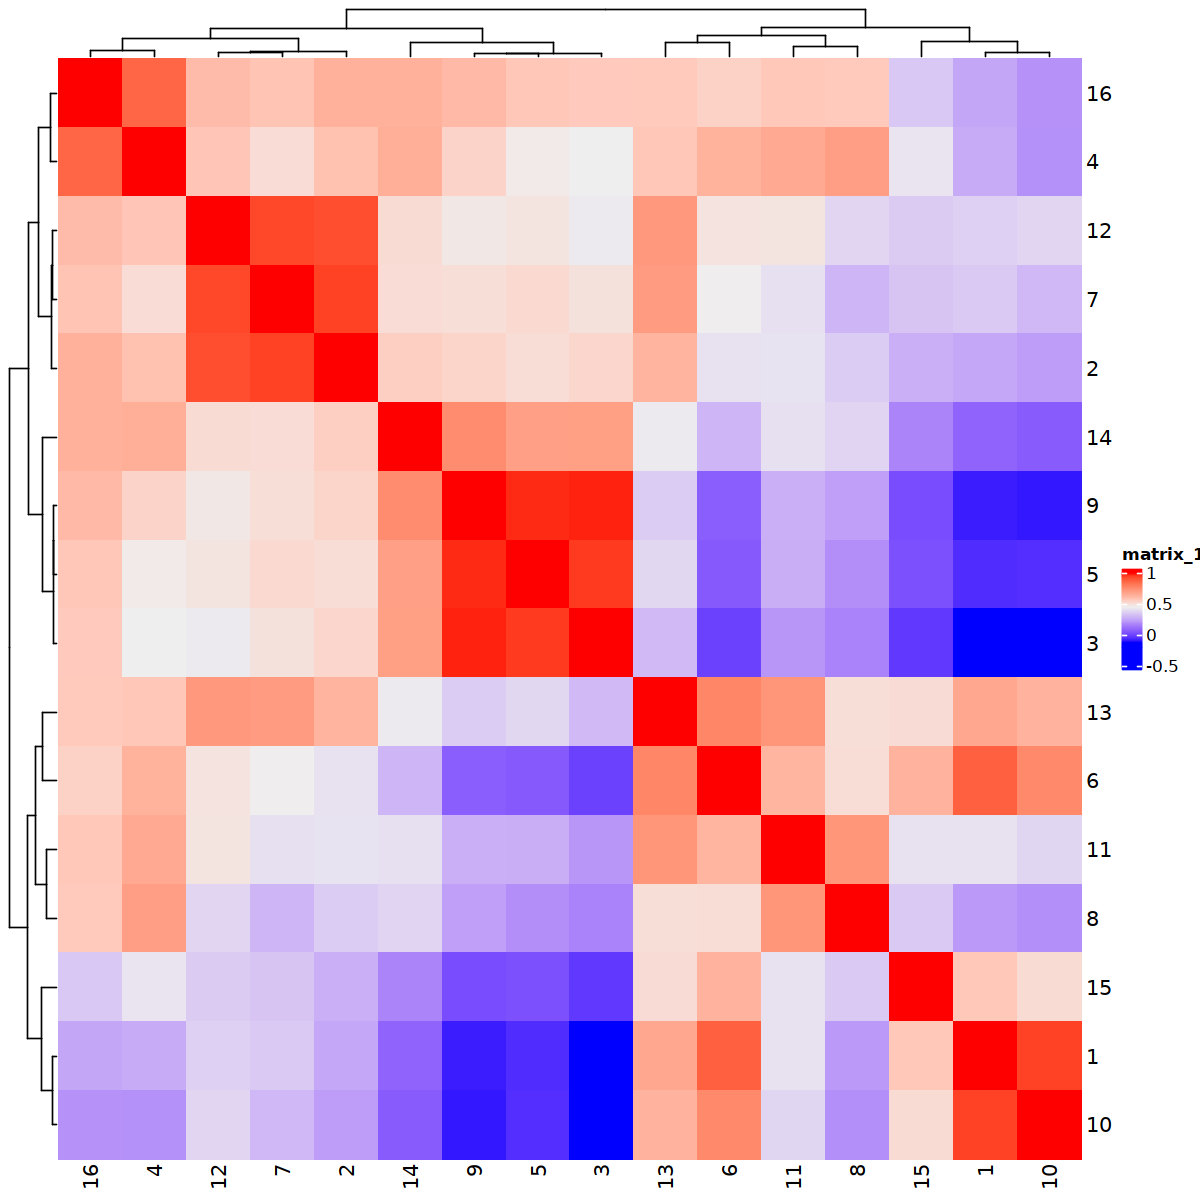

In [11]:
Uro_P1.leaf.corr <- marker_correlation(Uro_P1.leaf,
           meta_slot = "meta",
           counts_raw = "acr_counts_raw",
           cluster_name = "LouvainClusters")

library(modelr)
combined_louvain_clusters <- as_tibble(Uro_P1.leaf.corr$corr_matrix) %>%
    pivot_longer(!geneID, names_to = "cluster_name", values_to = "score")  %>% 
    group_by(geneID)  %>% 
      summarize(mean = mean(score),
            var = var(score))

regression <- loess(var ~ mean, data=combined_louvain_clusters)

combined_louvain_clusters.final <- combined_louvain_clusters %>% 
    add_residuals(regression)  %>% 
    arrange(resid, desc = FALSE)  %>% 
    top_n(500)

options(repr.plot.width=10, repr.plot.height=10)
corr_matrix <- Uro_P1.leaf.corr$corr_matrix

viz_matrix <- as_tibble(corr_matrix)  %>% 
    dplyr::filter(geneID %in% combined_louvain_clusters.final$geneID)  %>% 
    dplyr::select(-geneID)

Lc_corr_matrix <- cor(data.matrix(viz_matrix))

suppressPackageStartupMessages(library(ComplexHeatmap))
library(ComplexHeatmap)
Heatmap(Lc_corr_matrix)